In [43]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import math
import os
from scipy import sparse, stats

from matplotlib import pyplot as plt
SEED = 923984

In [44]:
from models.activation_functions import tanh, heaviside, sigmoid

activation_function = lambda x : tanh(x)

# Loading and Preprocessing

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Regression : http://tseregression.org/ + https://arxiv.org/pdf/2012.02974

Prediction Datasets available :

* MackeyGlass
* Lorenz
* Sunspot

Classification Datasets available :

* Custom :  FSDD, JapaneseVowels
* Aeon : SpokenArabicDigits, CatsDogs, LSST
* Torchaudio: SPEECHCOMMANDS

More on https://www.timeseriesclassification.com/dataset.php or https://pytorch.org/audio/stable/datasets.html

In [45]:
#Preprocessing
from datasets.spectral_decomposition import generate_multivariate_dataset
from sklearn.preprocessing import MinMaxScaler
from datasets.preprocessing import scale_data
from datasets.preprocessing import add_noise
from datasets.load_data import load_data as load_dataset
from datasets.peak_centered_decomposition import process_instance_func, extract_peak_frequencies

# Noise parameter (not used here)
noise_std = 0.001

data_type = "normal" # "normal" ou "noisy"

def load_data(dataset_name, spectral_representation, data_type, noise_std, step_ahead=5, visualize=False):
    (is_instances_classification, is_multivariate, sampling_rate,
         X_train_raw, X_test_raw, Y_train_raw, Y_test,
         use_spectral_representation, groups) = load_dataset(dataset_name, step_ahead, visualize=False)

    if is_multivariate:
        X_train_band, X_test_band = X_train_raw, X_test_raw
    else:
        X_test, X_train = X_test_raw, X_train_raw
    X_val_band, X_val = None, None
    del X_train_raw, X_test_raw
    Y_train = Y_train_raw
    del Y_train_raw

            
    # PREPROCESSING
    hop = 50 if is_instances_classification else 1
    win_length = edge_cut = 100
    if is_multivariate and use_spectral_representation:
        print("Data is already spectral, nothing to do")
    else:
        # choose the right source tensors
        base_train, base_test = (X_train_band, X_test_band) if is_multivariate else (X_train, X_test)

        if spectral_representation in ["stft", "mfcc"]:
            X_train_band = generate_multivariate_dataset(
                base_train, is_instances_classification, spectral_representation, hop=hop, win_length=win_length
            )
            X_test_band = generate_multivariate_dataset(
                base_test, is_instances_classification, spectral_representation, hop=hop, win_length=win_length
            )
        elif spectral_representation == "custom":

            peaks = extract_peak_frequencies(
                input_data=base_train,
                is_instances_classification=is_instances_classification,
                sampling_rate=sampling_rate,
                threshold=1e-5,
                smooth=True,
                window_length=10,
                nperseg=1024,
                visualize=True,
            )
            X_train_band = process_instance_func(base_train, is_instances_classification, sampling_rate, peaks)
            X_test_band = process_instance_func(base_test, is_instances_classification, sampling_rate, peaks)
        elif spectral_representation == "none":
            X_train_band = base_train
            X_test_band = base_test
                        
    # We cut the edges to remove the edges effects
    if not is_instances_classification:
        X_train_band = X_train_band[edge_cut:-edge_cut] 
        X_test_band = X_test_band[edge_cut:-edge_cut] 
        
        Y_train = Y_train[edge_cut:-edge_cut] 
        Y_test  = Y_test[edge_cut:-edge_cut]

    # NORMALIZATION
    scaler_multi = MinMaxScaler(feature_range=(0, 1))
    X_train_band, X_val_band, X_test_band = scale_data(X_train_band, X_val_band, X_test_band, scaler_multi, is_instances_classification)
    if not is_multivariate:
        scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
        X_train, X_val, X_test = scale_data(X_train, X_val, X_test, scaler_multi, is_instances_classification)       
    
    # OPTIONAL NOISE
    if data_type == "noisy":
        if is_instances_classification:
            # uni
            if not is_multivariate:
                X_train_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train, desc="TRAIN")]
                X_test_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test, desc="TEST")]
                
            # multi
            X_train_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train_band, desc="TRAIN")]
            X_test_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test_band, desc="TEST")]
        
        else:  #if prediction
            # uni
            if not is_multivariate:
                X_train_noisy = add_noise(X_train, noise_std)
                X_test_noisy = add_noise(X_test, noise_std)
        
            # multi
            X_train_band_noisy = add_noise(X_train_band, noise_std)
            X_test_band_noisy = add_noise(X_test_band, noise_std)

    # PRETRAINING SET
    # Define the number of instances you want to select
    if is_instances_classification:
        num_samples_for_pretrain = 500 if len(X_train_band) >= 500 else len(X_train_band)
        indices = np.random.choice(len(X_train_band), num_samples_for_pretrain, replace=False)
    else:
        indices = range(len(X_train_band))
    
    if data_type == "noisy":
        if not is_multivariate:
            X_pretrain_noisy = np.array(X_train_noisy, dtype=object)[indices].flatten()
        X_pretrain_band_noisy = np.array(X_train_band_noisy, dtype=object)[indices]
    
    if not is_multivariate:
        X_pretrain = np.array(X_train, dtype=object)[indices].flatten()
    X_pretrain_band = np.array(X_train_band, dtype=object)[indices]

    return X_pretrain_band, X_train_band, X_test_band, Y_train, Y_test, is_multivariate, is_instances_classification

# Evaluation functions

In [46]:
from scipy import stats
from numpy import random

# Evaluating
from performances.esn_model_evaluation import train_model_for_classification, predict_model_for_classification, compute_score
from performances.esn_model_evaluation import (train_model_for_prediction, init_reservoir, init_ip_reservoir, init_local_rule_reservoir,
                                                init_ip_local_rule_reservoir, init_readout)
from analysis.richness import spectral_radius, pearson, squared_uncoupled_dynamics_alternative, distance_correlation
from models.reservoir import init_matrices
from hag.hag import run_algorithm


nb_jobs = 10
def evaluate_dataset_on_test(study, dataset_name, function_name, pretrain_data, train_data, test_data, Y_train, Y_test, is_instances_classification, nb_trials = 8, record_metrics=False, random_projection_experiment=False):
    # Collect all hyperparameters in a dictionary
    hyperparams = {param_name: param_value for param_name, param_value in study.best_trial.params.items()}
    print(hyperparams)
    leaky_rate = 1
    input_connectivity = 1

    # score for prediction
    if dataset_name == "Sunspot":
        start_step = 30
        end_step = 500
    else:
        start_step = 500
        end_step = 1500
    SLICE_RANGE = slice(start_step, end_step)

    if 'variance_target' not in hyperparams and 'min_variance' in hyperparams:
        hyperparams['variance_target'] = hyperparams['min_variance']
    if not is_instances_classification:
        hyperparams['use_full_instance'] = False

    RIDGE_COEF = 10**hyperparams['ridge']

    if function_name in ["hadsp", "desp"]:
        max_partners = np.inf

    scores = []
    if record_metrics:
        spectral_radii = []
        pearson_correlations = []
        CEVs = []
        dcors = []
    for i in range(nb_trials):
        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the models to be at least network_size
        K = math.ceil(hyperparams['network_size'] / common_size)
        n = common_size * K

        if function_name in ["diag_ee", "diag_ei"]:
            use_block = True
        else:
            use_block = False

        # UNSUPERVISED PRETRAINING
        if function_name == "random_ee":
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(loc=0, scale=1), use_block=use_block, seed=random.randint(0, 1000), random_projection_experiment=random_projection_experiment)
        else:
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(loc=-1, scale=2), use_block=use_block, seed=random.randint(0, 1000), random_projection_experiment=random_projection_experiment)
        bias *= hyperparams['bias_scaling']
        Win *= hyperparams['input_scaling']

        if function_name == "hadsp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data,
                                     hyperparams['weight_increment'], hyperparams['target_rate'], hyperparams['rate_spread'], function_name,
                                     multiple_instances=is_instances_classification,
                                     min_increment = hyperparams['min_increment'], max_increment=hyperparams['max_increment'], use_full_instance=hyperparams['use_full_instance'],
                                     max_partners=max_partners, method="pearson", n_jobs=nb_jobs)
        elif function_name == "desp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data,
                                         hyperparams['weight_increment'], hyperparams['variance_target'], hyperparams['variance_spread'], function_name,
                                         multiple_instances=is_instances_classification,
                                         min_increment = hyperparams['min_increment'], max_increment=hyperparams['max_increment'], use_full_instance = hyperparams['use_full_instance'],
                                         max_partners=max_partners, method = "pearson",
                                         intrinsic_saturation=hyperparams['intrinsic_saturation'], intrinsic_coef=hyperparams['intrinsic_coef'],
                                         n_jobs = nb_jobs)
        elif function_name in ["random_ee", "random_ei", "diag_ee", "diag_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))
        else:
            raise ValueError(f"Invalid function: {function_name}")

        # unsupervised local rules
        if is_instances_classification:
            unsupervised_pretrain = np.concatenate(pretrain_data).astype(float)
        else:
            unsupervised_pretrain = pretrain_data.astype(float)
        if function_name == "ip_correct":
            reservoir = init_ip_reservoir(W, Win, bias, mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                          leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function
                                          )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        elif function_name == "anti-oja_fast":
            reservoir = init_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                  synapse_normalization=False, bcm_theta=None,
                                                  leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                  )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        elif function_name == "ip-anti-oja_fast":
            reservoir = init_ip_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                      synapse_normalization=False, bcm_theta=None,
                                                      mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                                      leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                      )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        else:
            reservoir = init_reservoir(W, Win, bias, leaky_rate, activation_function)
        readout = init_readout(ridge_coef=RIDGE_COEF)


        # TRAINING and EVALUATION
        if record_metrics:
            inputs = np.concatenate(test_data, axis=0) if is_instances_classification else test_data
            states_history_multi = reservoir.run(inputs)

            sr = spectral_radius(W)
            pearson_correlation, _ = pearson(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=False)
            CEV = squared_uncoupled_dynamics_alternative(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=True)
            dcor = distance_correlation(states_history_multi, num_windows=1, size_window=len(states_history_multi), step_size = 1, show_progress=True, method="auto", nb_jobs=nb_jobs)

            spectral_radii.append(sr)
            pearson_correlations.append(pearson_correlation[0])
            CEVs.append(CEV[0])
            dcors.append(dcor[0])
        else:
            if is_instances_classification:
                mode = "sequence-to-vector"
                train_model_for_classification(reservoir, readout, train_data, Y_train, n_jobs = nb_jobs, mode=mode)

                Y_pred = predict_model_for_classification(reservoir, readout, test_data, n_jobs = nb_jobs, mode=mode)
                score = compute_score(Y_pred, Y_test, is_instances_classification)
            else:
                esn = train_model_for_prediction(reservoir, readout, train_data, Y_train, warmup=start_step, n_jobs = nb_jobs)

                Y_pred =  esn.run(test_data, reset=False)
                score = compute_score(Y_pred[SLICE_RANGE], Y_test[SLICE_RANGE], is_instances_classification)

            scores.append(score)

    if record_metrics:
        return spectral_radii, pearson_correlations, CEVs, dcors

    return scores



In [47]:
import torch
from torch.utils.data import DataLoader

from performances.esn_model_evaluation import compute_score
from models.rnn import (
    LSTMModel, RNNModel, GRUModel,
    SequenceDataset, PrecomputedForecastDataset, make_sliding_windows,
    pad_collate, BucketBatchSampler,
    train as lstm_train,
    evaluate as lstm_evaluate,
)

# new imports for HAG branch
from performances.utility import retrieve_best_model
from hag.hag import run_algorithm
from models.reservoir import init_matrices
import math
from scipy import stats
from numpy import random

# device setup
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")


nb_jobs = 8
def evaluate_dataset_on_test_rnn(
    study,
    dataset_name,
    function_name,        # e.g. "lstm_last", "rnn", "rnn-mean_hag"
    pretrain_data,        # list/array of pretraining bands for HAG
    X_train,              # list of train sequences or array
    X_test,               # list of test sequences or array
    Y_train,              # labels or targets for train
    Y_test,               # labels or targets for test
    is_instances_classification,
    nb_trials=8,
    record_metrics=False
):
    # 1) best hyperparameters for LSTM/RNN
    hp = study.best_trial.params.copy()
    batch_size = hp.pop("batch_size")
    epochs     = hp.pop("epochs")
    lr         = hp.pop("learning_rate")
    nlayers    = hp.pop("num_layers")
    dropout    = hp.pop("dropout")
    
    if function_name in ["lstm", "rnn", "lstm_last", "gru"]:
            hidden     = hp.pop("hidden_size")
            bidir      = hp.pop("bidirectional")

    task_type = "classification" if is_instances_classification else "regression"
    criterion = torch.nn.CrossEntropyLoss() if task_type=="classification" else torch.nn.MSELoss()

    # for regression forecast slicing
    if not is_instances_classification:
        SLICE_RANGE = slice(500,1500) if dataset_name!="Sunspot" else slice(30,500)

    all_scores = []

    for seed in tqdm.tqdm(range(nb_trials), desc="Seeds", unit="seed"):
        torch.manual_seed(seed)

        # — build PyTorch Dataset & DataLoader —
        if is_instances_classification:
            train_ds = SequenceDataset(X_train, Y_train)
            train_lens = [len(x) for x in X_train]
            if len(set(train_lens))>1:
                sampler = BucketBatchSampler(train_lens, batch_size=batch_size, bucket_size=batch_size*20, shuffle=True)
                train_loader = DataLoader(train_ds, batch_sampler=sampler, collate_fn=pad_collate)
            else:
                train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)

            test_ds = SequenceDataset(X_test, Y_test)
            test_lens = [len(x) for x in X_test]
            if len(set(test_lens))>1:
                sampler = BucketBatchSampler(test_lens, batch_size=batch_size, bucket_size=batch_size*20, shuffle=False)
                test_loader = DataLoader(test_ds, batch_sampler=sampler, collate_fn=pad_collate)
            else:
                test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=pad_collate)

        else:
            WINDOW = 100
            X_tr_win, y_tr_tgt = make_sliding_windows(X_train, y=Y_train, window=WINDOW)
            X_test_win, y_test_tgt = make_sliding_windows(X_test, y=Y_test, window=WINDOW)

            train_ds = PrecomputedForecastDataset(X_tr_win, y_tr_tgt)
            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

            test_ds = PrecomputedForecastDataset(X_test_win, y_test_tgt)
            test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

        # infer dims
        sample_x, sample_y = train_ds[0]
        D_in  = sample_x.shape[-1]
        if task_type=="classification":
            D_out = sample_y.shape[-1]
        else:
            D_out = sample_y.shape[-1] if sample_y.ndim>0 else 1

        # instantiate models
        if function_name == "lstm_last":
            model = LSTMModel(
                input_size=D_in,
                hidden_size=hidden,
                num_layers=nlayers,
                output_size=D_out,
                dropout=dropout,
                bidirectional=bidir
            ).to(DEVICE)

        elif function_name == "gru":
            model = GRUModel(
                input_size=D_in,
                hidden_size=hidden,
                num_layers=nlayers,
                output_size=D_out,
                dropout=dropout,
                bidirectional=bidir
            ).to(DEVICE)

        elif function_name == "rnn":
            model = RNNModel(
                input_size=D_in,
                hidden_size=hidden,
                num_layers=nlayers,
                output_size=D_out,
                dropout=dropout,
                bidirectional=bidir
            ).to(DEVICE)

        elif function_name == "rnn-mean_hag":
            # HAG-based reservoir initialization
            # 1) Retrieve best HAG hyperparameters
            hag_study = retrieve_best_model("hadsp", dataset_name, False, variate_type="multi", data_type="normal")
            hyper = {k: v for k, v in hag_study.best_trial.params.items()}
            if 'variance_target' not in hyper and 'min_variance' in hyper:
                hyper['variance_target'] = hyper.pop('min_variance')
            hyper['use_full_instance'] = not is_instances_classification

            # 2) Build reservoir matrices
            input_connectivity = 1
            common_size = X_train[0].shape[1] if is_instances_classification else X_train.shape[1]
            K = math.ceil(hyper['network_size'] / common_size)
            n = common_size * K
            Win, W, bias = init_matrices(n, input_connectivity, hyper['connectivity'], K,
                w_distribution=stats.uniform(loc=-1, scale=2), seed=random.randint(0, 1000))
            bias *= hyper['bias_scaling']
            Win *= hyper['input_scaling']

            # 3) Adapt weights via HAG
            activation_function = np.tanh
            fold_idx = seed
            X_pre = pretrain_data
            W, _ = run_algorithm(
                W, Win, bias,
                hyper['leaky_rate'], activation_function,
                X_pre, hyper['weight_increment'],
                hyper['target_rate'], hyper['rate_spread'],
                function_name, multiple_instances=is_instances_classification,
                min_increment=hyper['min_increment'], max_increment=hyper['max_increment'],
                use_full_instance=hyper['use_full_instance'], max_partners=np.inf,
                method="pearson", n_jobs=nb_jobs
            )

            # 4) Readout training
            from performances.esn_model_evaluation import train_model_for_classification, train_model_for_prediction, init_readout, init_reservoir
            reservoir = init_reservoir(W, Win, bias, hyper['leaky_rate'], activation_function)
            RIDGE_COEF = 10 ** hyper['ridge']
            readout = init_readout(ridge_coef=RIDGE_COEF)
            start_step = SLICE_RANGE.start if not is_instances_classification else None
            if is_instances_classification:
                train_model_for_classification(reservoir, readout, X_train, Y_train, n_jobs=1, mode="sequence-to-vector")
            else:
                _ = train_model_for_prediction(reservoir, readout, X_train, Y_train, warmup=start_step, n_jobs=nb_jobs)
            Wout = readout.Wout
            bias_out = readout.bias.reshape(-1)

            # 5) Instantiate PyTorch RNNModel and overwrite weights
            model = RNNModel(
                input_size=D_in,
                hidden_size=n,
                num_layers=1,
                output_size=D_out,
                dropout=dropout,
                bidirectional=False
            ).to(DEVICE)
            with torch.no_grad():
                model.rnn.weight_ih_l0.copy_(torch.tensor(Win, dtype=torch.float32, device=DEVICE))
                model.rnn.weight_hh_l0.copy_(torch.tensor(W, dtype=torch.float32, device=DEVICE))
                model.rnn.bias_ih_l0.zero_()
                model.rnn.bias_hh_l0.copy_(torch.tensor(bias, dtype=torch.float32, device=DEVICE))
                model.fc.weight.copy_(torch.tensor(Wout.T, dtype=torch.float32, device=DEVICE))
                model.fc.bias.copy_(torch.tensor(bias_out, dtype=torch.float32, device=DEVICE))
        else:
            raise ValueError(f"Unknown function_name: {function_name}")


        # Train
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        model = torch.compile(model)
        # train for a few epochs
        for _ in range(epochs):
            _ = lstm_train(model, train_loader, criterion, optimizer, task_type=task_type)
            
        # evaluate
        metric = lstm_evaluate(model, test_loader, task_type=task_type)
        all_scores.append(metric)

    if record_metrics:
        raise NotImplementedError("Hidden-state metrics for LSTM not yet supported.")
    return all_scores


# Common visualisation definitions

In [52]:
from seaborn import color_palette

# -- Define color palettes for each group --
blues = color_palette("Blues", 5)      # shades of blue
oranges = color_palette("Oranges", 2)  # shades of orange
greens = color_palette("Greens", 2)    # shades of green
reds = color_palette("Reds", 2)    # shades of red
greys = color_palette("Greys", 3)    # shades of greys

# -- Map each function to its color --
function_colors = {
    'E-ESN':                greens[0],
    'ESN':                  greens[1],
    'IP':                   blues[0],
    'Anti-Oja':             blues[1],
    'Anti-Oja-Fast':        blues[2],
    'IP +\nAnti-Oja':       blues[3],
    'IP +\nAnti-Oja\nFast': blues[4],
    'mean HAG':             oranges[0],
    'variance HAG':         oranges[1],
    'LSTM':                 greys[0],
#    'RNN':                  greys[1],
    'GRU':                  greys[2],
#    'RNN-HAG':              greys[2],
#    'diag EE':             reds[0],
#    'diag EI':             reds[1],
}

# If you want a specific order for the bars, you can enforce it:
functions_order = [
    'E-ESN',
    'ESN',
    'IP',
    'Anti-Oja',
    'IP +\nAnti-Oja',
    'mean HAG',
    'variance HAG',
#    'RNN',
#    'RNN-HAG',
    'LSTM',
    'GRU',
#    'diag EE',
#    'diag EI',
]

function_mapping = {
    'random_ee':        'E-ESN',
    'random_ei':        'ESN',
    'ip_correct':       'IP',
    'anti-oja_fast':    'Anti-Oja',
    'ip-anti-oja_fast': 'IP +\nAnti-Oja',
    'hadsp':            'mean HAG',
    'desp':             'variance HAG',
    'lstm_last':        'LSTM',
#    'rnn':              'RNN',
    'gru':              'GRU',
#    'rnn-mean_hag':     'RNN-HAG',
#    'diag_ei':        'diag EI',
#    'diag_ee':        'diag EE',
}

dataset_label_map = {"JapaneseVowels": "Japanese Vowels", "CatsDogs": "Cats vs Dogs", "FSDD": "FSDD"}


# Input matrix impact

In [17]:
outfile = "outputs/input_strategy.csv"
img_dir = "outputs/images"
os.makedirs(os.path.dirname(outfile), exist_ok=True)
os.makedirs(img_dir, exist_ok=True)


In [ ]:
from datetime import datetime
from pandas.errors import EmptyDataError

# ====================== CONFIG ======================
DATASETS = ["CatsDogs"]  # "CatsDogs", "FSDD", "JapaneseVowels"
data_type = "normal"  # or "noisy"
noise_std = 0.001

columns = ['Dataset', 'Function', 'Mapping', 'Representation', 'Average Score', 'Standard Deviation', 'Date']

# Create or repair the CSV header if file missing/empty
if (not os.path.exists(outfile)) or (os.path.getsize(outfile) == 0):
    pd.DataFrame(columns=columns).to_csv(outfile, index=False)

# ============== COLLECT RESULTS INTO CSV =================
all_new_rows = []

for dataset_name in DATASETS:
    # "mfcc", "custom", "none"
    for spectral_representation in ["none"]:
            print(f"\n===== DATASET: {dataset_name} =====")
        
            # load_data signature expected to return pretrain/train/test splits for evaluation
            # If your function’s signature differs, adapt here.
            (pretrain_data,
             train_data,
             test_data,
             Y_train,
             Y_test,
             is_multivariate,
             is_instances_classification) = load_data(dataset_name, spectral_representation, data_type, noise_std, visualize=False)

            # True, False
            for random_projection_experiment in [True, False]:
                print(f"--- Random projection: {random_projection_experiment} ---")
        
                prefix = f"rdn-proj_tpe_{spectral_representation}" if random_projection_experiment else f"mod-proj_tpe_{spectral_representation}"
                
                for function_name in ["random_ee", "random_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast", "hadsp", "desp"]:
                    print("Function:", function_name)
        
                    # Retrieve (or open) the best study matching your naming scheme
                    study = retrieve_best_model(
                        function_name=function_name,
                        dataset_name=dataset_name,
                        is_multivariate=is_multivariate,
                        variate_type="multi",      # matches your training loop
                        data_type=data_type,
                        prefix=prefix,             # <-- aligned with the new DB filenames
                    )
        
                    # Evaluate best params on test set a few times for stability
                    scores = evaluate_dataset_on_test(
                        study,
                        dataset_name,
                        function_name,
                        pretrain_data,
                        train_data,
                        test_data,
                        Y_train,
                        Y_test,
                        is_instances_classification,
                        nb_trials=8,
                        record_metrics=False,
                        random_projection_experiment=random_projection_experiment,
                    )
        
                    avg = float(np.mean(scores))
                    std = float(np.std(scores))
        
                    if is_instances_classification:
                        avg_fmt = f"{round(avg * 100, 5)} %"
                        std_fmt = f"± {round(std * 100, 5)} %"
                    else:
                        avg_fmt = f"{round(avg, 5)}"
                        std_fmt = f"± {round(std, 5)}"
        
                    mapping_label = "random" if random_projection_experiment else "modular"
        
                    all_new_rows.append({
                        'Dataset': dataset_name,
                        'Function': function_name,
                        'Mapping': mapping_label,
                        'Representation': spectral_representation,
                        'Average Score': avg_fmt,
                        'Standard Deviation': std_fmt,
                        'Date': datetime.now().strftime('%Y-%m-%d')
                    })

    
# Append to CSV atomically
if all_new_rows:
    new_results = pd.DataFrame(all_new_rows).reindex(columns=columns)
    print("\n== New results ==")
    print(new_results)

    try:
        prev = pd.read_csv(outfile)
    except (EmptyDataError, FileNotFoundError):
        prev = pd.DataFrame(columns=columns)

    combined = pd.concat([prev, new_results], ignore_index=True)

    tmp = outfile + ".tmp"
    combined.to_csv(tmp, index=False)
    os.replace(tmp, outfile)
    print(f"Results saved to {outfile}.")
else:
    print("No new studies found; nothing to append.")


### Grouped bar plot

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# --------- Matplotlib styling (clean, print-ready) ----------
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,  # embed text as text in PDFs
    "ps.fonttype": 42,
})

# ---- load & clean ----
df = pd.read_csv(outfile)
df.columns = [c.strip() for c in df.columns]

def numify(s):
    if pd.isna(s):
        return np.nan
    s = str(s).replace("%", "").replace("±", "").strip()
    return pd.to_numeric(s, errors="coerce")

df["Average Score"] = df["Average Score"].apply(numify)
df["Standard Deviation"] = df["Standard Deviation"].apply(numify)

# Apply pretty labels
df["Function_disp"] = df["Function"].map(function_mapping).fillna(df["Function"])
df["Dataset_disp"]  = df["Dataset"].map(dataset_label_map).fillna(df["Dataset"])

# Normalize mapping labels
if "Random Input Mapping" not in df.columns:
    raise ValueError("CSV must include 'Random Input Mapping' with values like 'modular'/'random'")
df["Random Input Mapping"] = df["Random Input Mapping"].astype(str).str.lower().map({"modular":"modular","random":"random"})

# Keep only functions we know (in case CSV holds others)
present_functions = [f for f in functions_order if f in df["Function_disp"].unique()]
if not present_functions:
    present_functions = sorted(df["Function_disp"].unique())

mappings = [m for m in ["modular","random"] if m in df["Random Input Mapping"].unique()]

# Consistent dataset order
datasets = [dataset_label_map.get(k, k) for k in ["JapaneseVowels","CatsDogs","FSDD"] if k in df["Dataset"].unique()]
# include any extras not in the preferred list
datasets += [dataset_label_map.get(d, d) for d in df["Dataset"].unique() if dataset_label_map.get(d, d) not in datasets]

# ---- Grouped bar plot: Average Score with error bars ----
x = np.arange(len(datasets))  # dataset positions
width = 0.08                  # narrow bars to fit many
fontsize = 12
fig, ax = plt.subplots(figsize=(max(10, 1.5*len(datasets)+4), 6))

mapping_hatching = {"modular": "", "random": "///"}

for i, func in enumerate(present_functions):
    for j, mapping in enumerate(mappings):
        offset = i * (len(mappings) * width) + j * width

        sub = df[(df["Function_disp"] == func) & (df["Random Input Mapping"] == mapping)]
        # align to dataset positions
        merged = pd.DataFrame({"Dataset_disp": datasets}).merge(sub, on="Dataset_disp", how="left")

        color = function_colors.get(func, "gray")
        hatch = mapping_hatching.get(mapping, "")

        ax.bar(
            x + offset,
            merged["Average Score"],
            width,
            yerr=merged["Standard Deviation"],
            capsize=3,
            color=color,
            hatch=hatch,
            edgecolor="black",
            label=None
        )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="both", labelsize=fontsize)
ax.set_xlabel("Dataset", fontsize=fontsize)
ax.set_ylabel("Average Score", fontsize=fontsize)  # (%) for classification, raw for regression

# center ticks under grouped bars
group_width = len(present_functions) * len(mappings) * width
ax.set_xticks(x + group_width/2 - (width/2))
ax.set_xticklabels(datasets, rotation=0)

# legends
func_legend = [Patch(facecolor=function_colors.get(f,"gray"), edgecolor="black", label=f) for f in present_functions]
map_legend = [Patch(facecolor="white", edgecolor="black", hatch=mapping_hatching[m], label=m.title()) for m in mappings]

first_legend = ax.legend(handles=func_legend, title="Function", loc="upper left", fontsize=fontsize)
ax.add_artist(first_legend)
ax.legend(handles=map_legend, title="Input Mapping", loc="lower left", fontsize=fontsize)

plt.tight_layout()
png_out = os.path.join(img_dir, "bar_input_strategy.png")
pdf_out = os.path.join(img_dir, "bar_input_strategy.pdf")
fig.savefig(png_out, bbox_inches="tight")
fig.savefig(pdf_out, bbox_inches="tight")
print(f"Saved {png_out} and {pdf_out}")
plt.close(fig)

Saved outputs/images/bar_input_strategy.png and outputs/images/bar_input_strategy.pdf


### Heatmap

Saved outputs/images/bar_input_strategy.png and outputs/images/heatmap_deltas.pdf

Average gain of Modular over Random (pp):
  Japanese Vowels: +0.77 pp
  Cats vs Dogs: +3.01 pp
  FSDD: +10.60 pp
  Overall: +4.79 pp


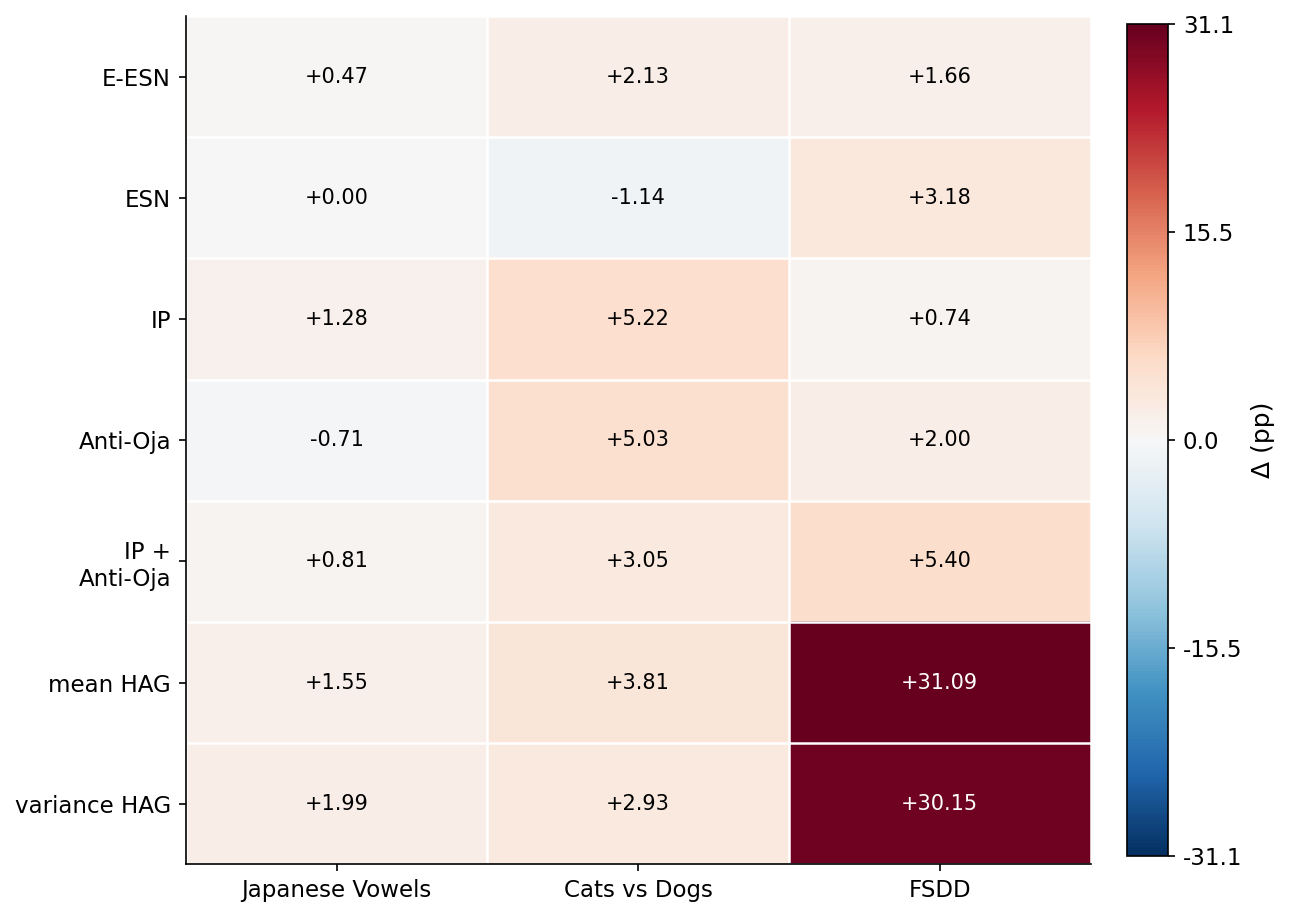

In [49]:
# ===== Visualization (fixed) =====
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.patches import Patch

outfile = "outputs/input_strategy.csv"
img_dir = "outputs/images"
os.makedirs(img_dir, exist_ok=True)

# ---- load & clean ----
df = pd.read_csv(outfile)
df.columns = [c.strip() for c in df.columns]

# harmonize column names from earlier runs
if 'Random Input Mapping' in df.columns and 'Mapping' not in df.columns:
    df = df.rename(columns={'Random Input Mapping': 'Mapping'})

# OPTIONAL: filter a single representation
# df = df[df['Representation'] == 'mfcc']

# parse "Average Score" (strings like "85.123 %") into numeric percentage points
def to_pp(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    if x.endswith('%'):
        x = x[:-1].strip()  # keep number in percent points (e.g., "85.1" == 85.1 pp)
    # also strip any leading "±"
    x = x.replace('±','').strip()
    try:
        return float(x)
    except ValueError:
        return np.nan

df['Average Score (pp)'] = df['Average Score'].apply(to_pp)

# ---- Heatmap: Δ (Modular − Random), in percentage points (pp) ----
# Build wide table: modular/random side-by-side then Δ
wide = (
    df.pivot_table(index=['Dataset','Function'],
                   columns='Mapping',
                   values='Average Score (pp)',
                   aggfunc='mean')
      .reset_index()
)

if {'modular','random'}.issubset(set(wide.columns)):
    wide['delta_pp'] = wide['modular'] - wide['random']
else:
    wide['delta_pp'] = np.nan

# Order datasets/functions if you like; otherwise keep encountered order
dataset_order_raw = [k for k in ["JapaneseVowels","CatsDogs","FSDD"] if k in wide['Dataset'].unique()]
if not dataset_order_raw:
    dataset_order_raw = list(wide['Dataset'].unique())

# map name with function_mapping
wide['Function'] = wide['Function'].map(function_mapping).fillna(wide['Function'])
fn_order = [f for f in functions_order if f in wide['Function'].unique()]
if not fn_order:
    fn_order = sorted(wide['Function'].unique())

heat = (
    wide.pivot_table(index='Function', columns='Dataset', values='delta_pp')
        .reindex(index=fn_order, columns=dataset_order_raw)
)

# Pretty display labels (optional)
dataset_label_map = {"JapaneseVowels": "Japanese Vowels", "CatsDogs": "Cats vs Dogs", "FSDD": "FSDD"}
col_labels = [dataset_label_map.get(d, d) for d in heat.columns]
row_labels = list(heat.index)

# Styling
mpl.rcParams.update({"figure.dpi": 150, "savefig.dpi": 600})
v = np.nanmax(np.abs(heat.values))
if not np.isfinite(v):
    v = 1.0
norm = mpl.colors.TwoSlopeNorm(vmin=-v, vcenter=0.0, vmax=v)
cmap = plt.get_cmap("RdBu_r").copy()
cmap.set_bad("#eeeeee")

data = np.ma.masked_invalid(heat.values)

fig, ax = plt.subplots(
    figsize=(1.9*len(col_labels) + 2.8, 0.55*len(row_labels) + 2.2),
    layout="constrained"
)
im = ax.imshow(data, cmap=cmap, norm=norm, aspect="auto")

# Ticks
ax.set_xticks(np.arange(len(col_labels)))
ax.set_xticklabels(col_labels)
ax.set_yticks(np.arange(len(row_labels)))
ax.set_yticklabels(row_labels)

# Gridlines
ax.set_xticks(np.arange(-0.5, data.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, data.shape[0], 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=1.2)
ax.tick_params(which="minor", bottom=False, left=False)
for spine in ("top","right"):
    ax.spines[spine].set_visible(False)

# Annotate each cell
def luminance(rgb):
    r, g, b = rgb[:3]
    return 0.2126*r + 0.7152*g + 0.0722*b

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        val = heat.values[i, j]
        if np.isnan(val):
            continue
        rgba = cmap(norm(val))
        txt_color = "white" if luminance(rgba) < 0.45 else "black"
        ax.text(j, i, f"{val:+.2f}", ha="center", va="center", fontsize=10, color=txt_color)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ticks = np.linspace(-v, v, 5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1f}" for t in ticks])
cbar.set_label("Δ (pp)")

pdf_out = os.path.join(img_dir, "heatmap_deltas.pdf")
fig.savefig(pdf_out, bbox_inches="tight")
print(f"Saved {png_out} and {pdf_out}")

# ---- Textual summary ----
by_ds = (wide.groupby("Dataset")["delta_pp"].mean().reindex(dataset_order_raw))
overall = wide["delta_pp"].mean()

print("\nAverage gain of Modular over Random (pp):")
for ds, v in by_ds.items():
    ds_disp = dataset_label_map.get(ds, ds)
    print(f"  {ds_disp}: {v:+.2f} pp")
print(f"  Overall: {overall:+.2f} pp")

# Dataset characteristics

In [26]:
datasets = [
    "CatsDogs", "FSDD", "JapaneseVowels", "SPEECHCOMMANDS", "SpokenArabicDigits"
]

for dataset_name in datasets:
    (is_instances_classification, is_multivariate, sampling_rate,
     X_train_raw, X_test_raw, Y_train_raw, Y_test,
     use_spectral_representation, groups) = load_dataset(dataset_name, 5, visualize=False)

    # Compute the length of each instance (assuming each instance is a 1D sequence)
    lengths = [len(x) for x in X_train_raw]
    avg_length = sum(lengths) / len(lengths)
    
    print(f"Dataset: {dataset_name}  -->  Average length of X_train_raw: {avg_length:.2f}")

 Number of instances =  164
 Shape of X =  (14773, 1)
 Shape of y =  (164, 2)
 Meta data =  {'problemname': 'heartbeat', 'timestamps': False, 'missing': False, 'univariate': True, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['0', '1']}
Multivariate =  False
Dataset: CatsDogs  -->  Average length of X_train_raw: 14773.00
Number of audio files: 3000
Mean sampling rate: 8000
Dataset: FSDD  -->  Average length of X_train_raw: 3842.50
Dataset: JapaneseVowels  -->  Average length of X_train_raw: 15.83


KeyboardInterrupt: 

In [33]:
# Define the dataset list
datasets = [
    "MackeyGlass", "Lorenz", "Sunspot_daily", "Henon", "NARMA", "CatsDogs", 
    "FSDD", "JapaneseVowels", "SPEECHCOMMANDS", "SpokenArabicDigits"
]

# Function to test dataset characteristics
def dataset_characteristics(dataset, data_type, noise_std):
    spectral_representation = "mfcc" if dataset in ["CatsDogs", "FSDD", "JapaneseVowels", "SPEECHCOMMANDS", "SpokenArabicDigits"] else "stft"
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, spectral_representation, data_type, noise_std, visualize=False)

    # Score for prediction
    if dataset == "Sunspot":
        start_step = 30
        end_step = 500
    else:
        start_step = 500
        end_step = 1500
    SLICE_RANGE = slice(start_step, end_step)

    common_index = 1
    if is_instances_classification:
        common_size = pretrain_data[0].shape[common_index]
    else:
        common_size = pretrain_data.shape[common_index]

    # We want the size of the models to be at least network_size
    network_size = 500
    K = math.ceil(network_size / common_size)
    n = common_size * K

    # Pretraining dataset processing
    if is_instances_classification:
        unsupervised_pretrain = np.concatenate(pretrain_data).astype(float)
    else:
        unsupervised_pretrain = pretrain_data.astype(float)

    # **Calculate total step count**
    if is_instances_classification:
        total_pretrain_length = sum(instance.shape[0] for instance in pretrain_data)
        total_train_length = sum(instance.shape[0] for instance in train_data)
        total_test_length = sum(instance.shape[0] for instance in test_data)
        original_dimension = train_data[0].shape[1]
        number_class = Y_test.shape[1]
        
        # Calculate min, max and average sample size over test+train datasets
        sample_sizes = [instance.shape[0] for instance in train_data] + [instance.shape[0] for instance in test_data]
        min_sample_size = min(sample_sizes)
        max_sample_size = max(sample_sizes)
        avg_sample_size = sum(sample_sizes) / len(sample_sizes)
    else:
        total_pretrain_length = pretrain_data.shape[0]
        total_train_length = train_data.shape[0]
        total_test_length = test_data.shape[0]
        original_dimension = train_data.shape[1]
        number_class = 0
        min_sample_size = None
        max_sample_size = None
        avg_sample_size = None

    return {
        "dataset_name": dataset,
        "tot_pretrain_length": total_pretrain_length,
        "tot_train_length": total_train_length,
        "tot_test_length": total_test_length,
        "origin_dim": original_dimension,
        "nb_dupication": K,
        "reservoir_size": n,
        "final_dim": common_size,
        "nb_class": number_class,
        "min_sample_size": min_sample_size,
        "max_sample_size": max_sample_size,
        "avg_sample_size": avg_sample_size,
    }


# Run tests on all datasets
results = []
noise_std=0.001
for dataset in datasets:
    characteristics = dataset_characteristics(dataset, data_type, noise_std)
    results.append(characteristics)

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Save to CSV
csv_filename = "outputs/dataset_characteristics.csv"
df.to_csv(csv_filename, index=False)

print(f"Dataset characteristics saved to {csv_filename}")

Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (15000, 51)
Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (5000, 51)


/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `seed`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (15000, 153)
Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (5000, 153)
Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (66527, 51)
Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (7392, 51)
Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (15000, 102)
Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (5000, 102)
Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (15000, 51)
Using window length (nperseg): 100 and hop: 1
Dropped the last time frame to match expected shape.
X_band.shape (5000, 51)
 Number 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your samplin

Using window length (nperseg): 100 and hop: 50


[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    0.1s finished


Number of audio files: 3000
Mean sampling rate: 8000
Using window length (nperseg): 100 and hop: 50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s


Using window length (nperseg): 100 and hop: 50


[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


Data is already spectral, nothing to do


Exception ignored in: <function ResourceTracker.__del__ at 0x107484680>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105484680>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/opt/homebrew/Caskroom/miniforge/base/envs/hag_env/lib/python3.12/m

KeyboardInterrupt: 

# HPO Comparaison

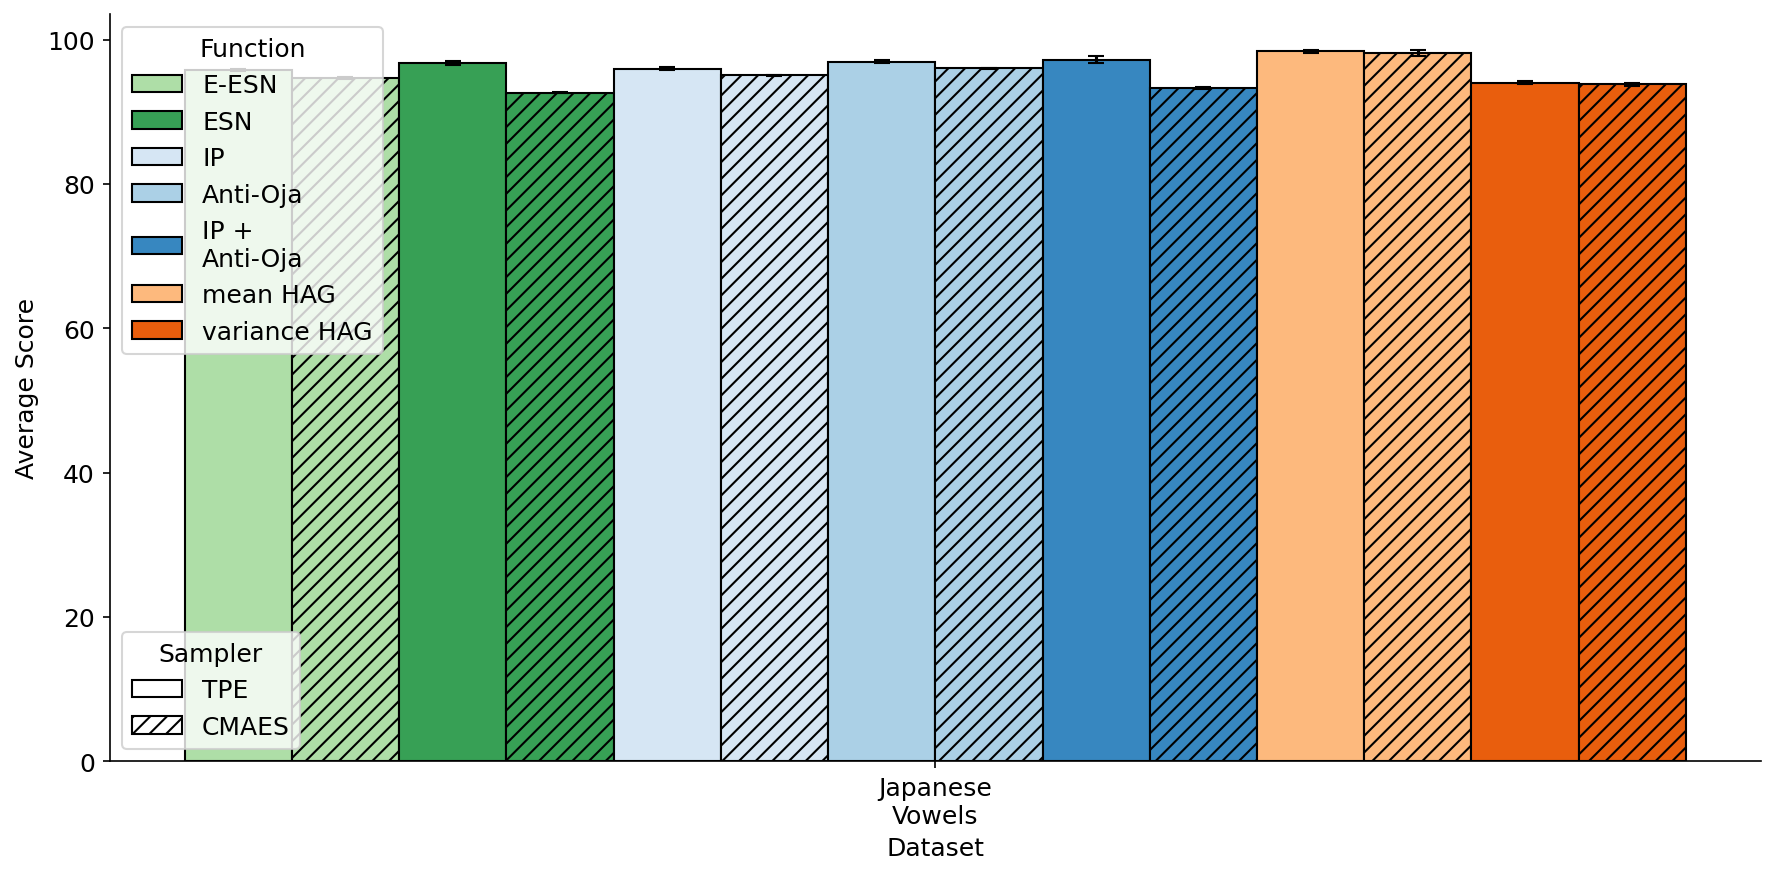

In [54]:
# Read your CSV file (already containing TPE vs. CMA-ES results)
file_name = "outputs/hpo_strategy.csv"
df = pd.read_csv(file_name)

# --- 1) Basic Cleanup ---
# Remove '%' from "Average Score" so we can convert to float
df['Average Score'] = pd.to_numeric(
    df['Average Score'].str.replace('%', ''), 
    errors='coerce'
)
# Remove '±' and '%' from "Standard Deviation"
df['Standard Deviation'] = pd.to_numeric(
    df['Standard Deviation'].str.replace('±', '').str.replace('%', ''), 
    errors='coerce'
)


# Rename functions for your final labels
df['Function'] = df['Function'].replace(function_mapping)

# Optional replacements for dataset names
df['Dataset'] = df['Dataset'].replace({
    'JapaneseVowels':     'Japanese\nVowels',
})

# 2b) distinguish TPE vs CMA-ES by hatch pattern (or alpha, edgecolor, etc.)
sampler_hatching = {
    'tpe':   '',     # no hatch
    'cmaes': '///',  # diagonal hatch
}


# Filter to only those in the DataFrame
functions = [f for f in functions_order if f in df['Function'].unique()]

# If you also want an explicit order for Sampler
samplers = ['tpe', 'cmaes']

# --- 3) Build the grouped bar chart ---

datasets = df['Dataset'].unique()
datasets.sort()  # optional: sort datasets alphabetically
x = np.arange(len(datasets))  # label locations
width = 0.08                  # narrower bar for more sub-bars

fig, ax = plt.subplots(figsize=(12, 6))
fontsize = 12

# Outer loop over functions
for i, func in enumerate(functions):
    # Inner loop over the two samplers
    for j, sampler in enumerate(samplers):
        # Horizontal offset for each bar
        # We have 2 samplers per function, so total sub-width = 2*width
        offset = i * (2 * width) + j * width

        # Extract rows for this function + sampler
        sub_df = df[(df['Function'] == func) & (df['Sampler'] == sampler)]

        # Merge with the dataset ordering to align bar positions
        merged = pd.DataFrame({'Dataset': datasets}).merge(sub_df, on='Dataset', how='left')

        # Plot the bars
        ax.bar(
            x + offset,
            merged['Average Score'],
            width,
            label=None,  # We'll manually handle legend
            yerr=merged['Standard Deviation'],
            capsize=4,
            color=function_colors.get(func, 'gray'),  # fallback color if missing
            hatch=sampler_hatching.get(sampler, ''),  # or '' if missing
            edgecolor='black'                         # optional to see the hatch better
        )

# --- 4) Cosmetic adjustments ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)

# X-axis label
ax.set_xlabel('Dataset', fontsize=fontsize)

# Y-axis label (change if classification vs. NRMSE)
# e.g., if your CSV is for classification, you might put "Classification Rate (%)"
ax.set_ylabel('Average Score', fontsize=fontsize)

# Position x-ticks in the center of each dataset group
total_functions = len(functions)
total_samplers = len(samplers)  # 2
group_width = total_functions * total_samplers * width
ax.set_xticks(x + group_width/2 - (width/2))
ax.set_xticklabels(datasets, rotation=0)

# --- 5) Build a custom legend ---
# 5a) Legend for the Functions (colors)
from matplotlib.patches import Patch

function_legend = [
    Patch(facecolor=function_colors[f], edgecolor='black', label=f) for f in functions
]

# 5b) Legend for the Samplers (hatching)
sampler_legend = [
    Patch(facecolor='white', edgecolor='black', hatch=sampler_hatching[s], 
          label=s.upper())  # or s.title()
    for s in samplers
]

# Combine them in one line, or do them separately
first_legend = ax.legend(handles=function_legend, title='Function', loc='upper left', fontsize=fontsize)
ax.add_artist(first_legend)  # explicitly add the first legend, then a second one
ax.legend(handles=sampler_legend, title='Sampler', loc='lower left', fontsize=fontsize)

plt.tight_layout()
plt.show()

# Test scores

In [23]:
import numpy as np

from datetime import datetime

from performances.utility import retrieve_best_model

# Create an empty DataFrame to store the results
columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
variate_type = "multi"  # "multi" or "uni"


for dataset_name in ["FSDD"]:
    new_results = pd.DataFrame(columns=columns)
    # Can be "MackeyGlass", "Lorenz", "Sunspot_daily", "CatsDogs", "JapaneseVowels", "FSDD", "SpokenArabicDigits", "SPEECHCOMMANDS"
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset_name, data_type, noise_std, visualize=True)
    if is_instances_classification:
        file_name = "outputs/test_results/test_results_classification.csv"
    else: 
        file_name = "outputs/test_results/test_results_prediction.csv"
    print(dataset_name)
    # Simulate your data and loop for evaluation
    
    # "random_ee", "random_ei", "diag_ee", "diag_ei", "ip_correct", "anti-oja_fast",  "ip-anti-oja_fast", "hadsp", "desp", "lstm_last", "rnn"
    for function_name in ["ip-anti-oja_fast"]:
        print(function_name)

        # dispatch to the correct evaluator
        if function_name in ["lstm_last", "rnn", "rnn-mean_hag", "gru"]:
            prefix = "lstm_tpe" if dataset_name == "SPEECHCOMMANDS" else "new_tpe"
            study = retrieve_best_model(function_name, dataset_name, is_multivariate, variate_type = "multi", data_type = "normal", prefix=prefix)
            scores = evaluate_dataset_on_test_rnn(
                study,
                dataset_name,
                function_name,
                pretrain_data,   # this arg is ignored by the LSTM evaluator
                train_data,
                test_data,
                Y_train,
                Y_test,
                is_instances_classification,
                nb_trials=8,
                record_metrics=False
            )
        else:
            study = retrieve_best_model(function_name, dataset_name, is_multivariate, variate_type = "multi", data_type = "normal", prefix="new_tpe")

            scores = evaluate_dataset_on_test(
                study, 
                dataset_name,
                function_name, 
                pretrain_data, 
                train_data, 
                test_data,
                Y_train, 
                Y_test,
                is_instances_classification,
                nb_trials = 8,
                record_metrics=False
            )
            
        # Compute the average and standard deviation of the scores
        average_score = np.mean(scores)
        std_deviation = np.std(scores)
    
        if is_instances_classification:
            formatted_average = f"{round(average_score * 100, 5)} %"
            formatted_std = f"± {round(std_deviation * 100, 5)} %"
        else:
            formatted_average = f"{round(average_score, 5)}"
            formatted_std = f"± {round(std_deviation, 5)}"
        
        # Capture the current date
        current_date = datetime.now().strftime('%Y-%m-%d')
        
        # Create a new DataFrame row with the Date column
        new_row = pd.DataFrame({
            'Dataset': [dataset_name],
            'Function': [function_name],
            'Average Score': [formatted_average],
            'Standard Deviation': [formatted_std],
            'Date': [current_date]
        })
        
        # Concatenate the new row to the results DataFrame
        new_results = pd.concat([new_results, new_row], ignore_index=True)
    
    
    # Display the DataFrame
    print(new_results)
    
    # Load the existing CSV
    if os.path.exists(file_name):
        previous_results = pd.read_csv(file_name)
    else:
        columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
        previous_results = pd.DataFrame(columns=columns)
        previous_results.to_csv(file_name, index=False)
        print(f"{file_name} created successfully.")
        
    tots_results = pd.concat([new_results, previous_results], axis=0)
    
    tots_results.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}.")

TypeError: load_data() missing 1 required positional argument: 'noise_std'

## Visualisation

In [55]:
import os
import pandas as pd 

file_name = "outputs/test_results/test_results_classification.csv"

if 'file_name' not in locals() and 'file_name' not in globals():
    file_name = "outputs/test_results/test_results_prediction.csv"  #  test_results_classification.csv or test_results_prediction.csv

if os.path.exists(file_name):
    previous_results = pd.read_csv(file_name)
else:
    # File does not exist, create it with the necessary columns
    columns = ['Dataset', 'Function', 'Average Score', 'Standard Deviation', 'Date']
    previous_results = pd.DataFrame(columns=columns)
    # Save the empty DataFrame as a CSV
    previous_results.to_csv(file_name, index=False)
    print(f"{file_name} created successfully.")

print(f"Results saved to {file_name}.")
previous_results

Results saved to outputs/test_results/test_results_classification.csv.


,Dataset,Function,Average Score,Standard Deviation,Date
0,JapaneseVowels,random_ee,97.2973 %,± 0.35753 %,2025-04-09
1,JapaneseVowels,random_ei,97.5 %,± 0.67229 %,2025-04-09
2,JapaneseVowels,diag_ee,96.58784 %,± 0.57233 %,2025-05-02
3,JapaneseVowels,diag_ei,97.43243 %,± 0.7524 %,2025-05-02
4,JapaneseVowels,ip_correct,96.89189 %,± 0.55718 %,2025-04-09
5,JapaneseVowels,anti-oja_fast,96.75676 %,± 0.27027 %,2025-04-09
6,JapaneseVowels,ip-anti-oja_fast,96.92568 %,± 0.404 %,2025-04-09
7,JapaneseVowels,hadsp,98.78378 %,± 0.13514 %,2025-04-09
8,JapaneseVowels,desp,98.41216 %,± 0.31511 %,2025-04-09
9,JapaneseVowels,lstm_last,85.63179 %,± 3.12924 %,2025-07-18


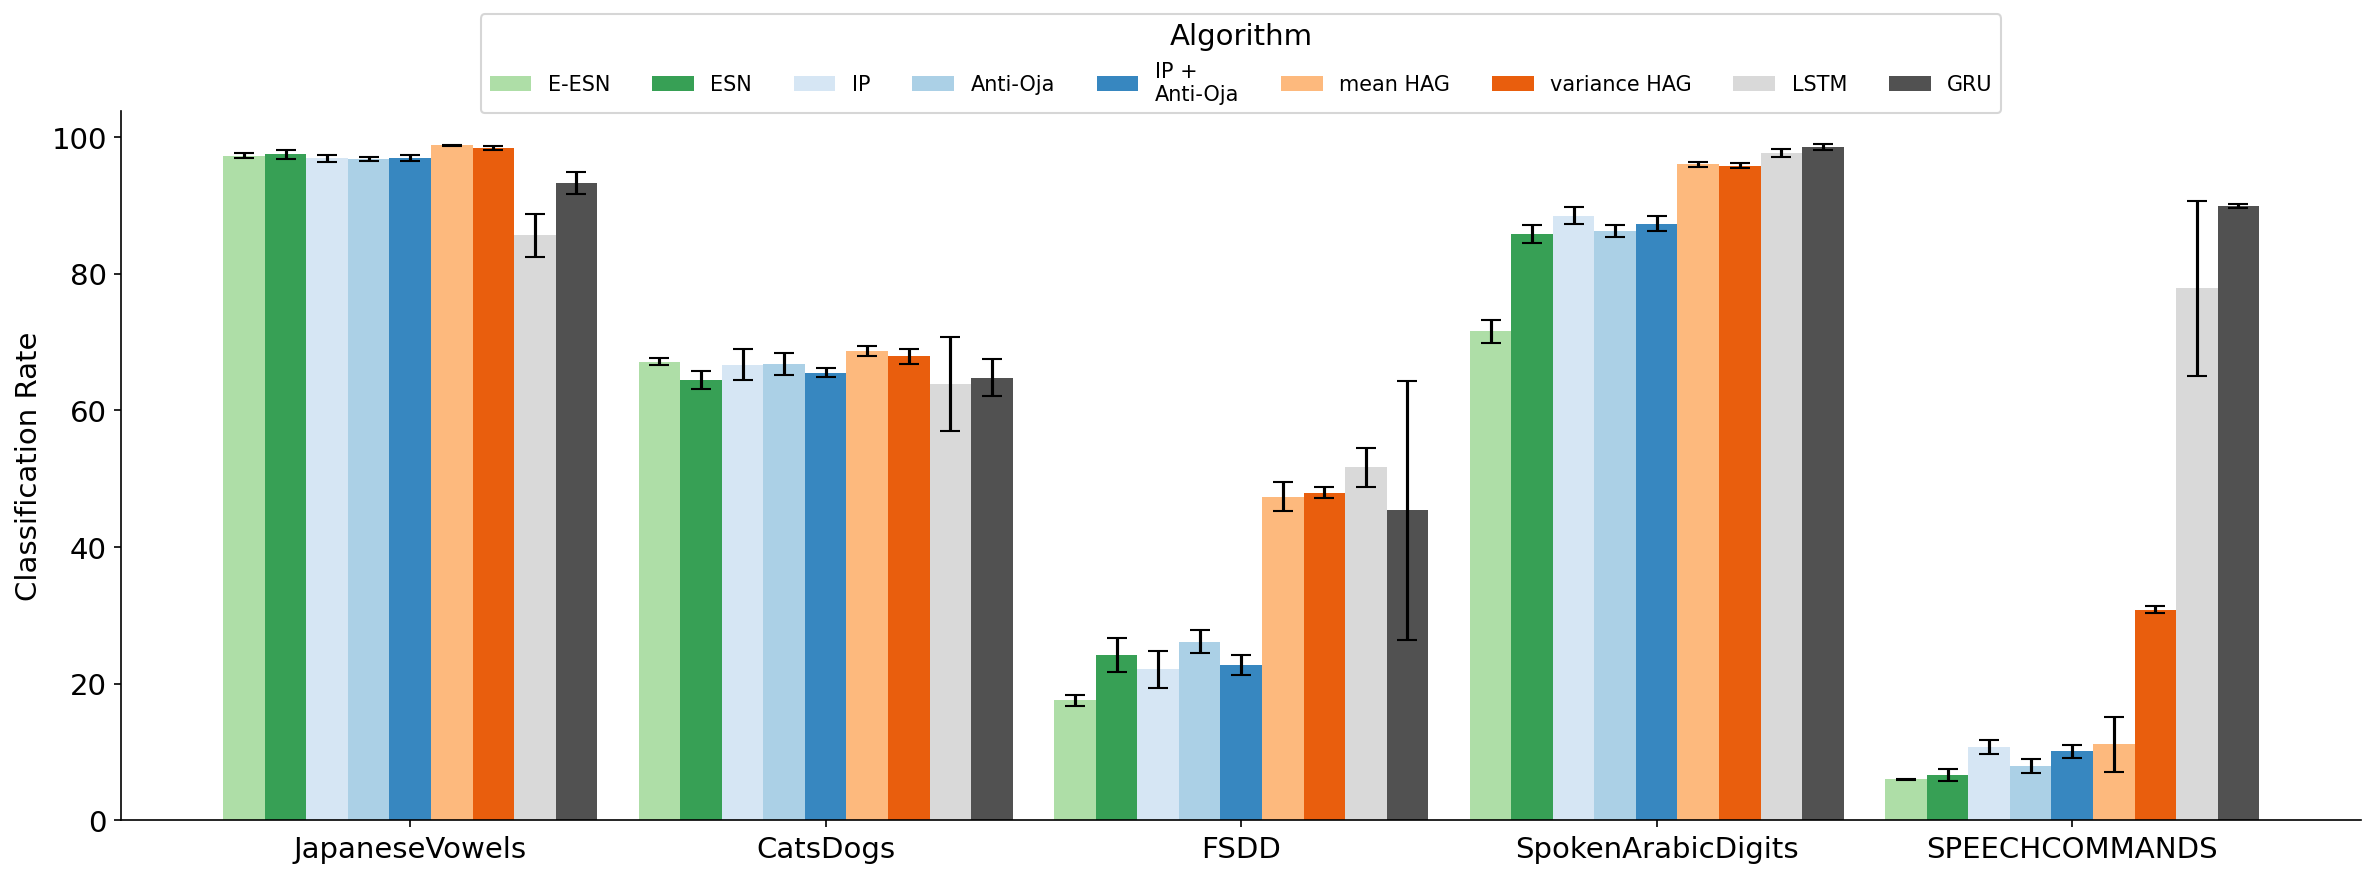

In [56]:
import pandas as pd

from matplotlib import pyplot as plt
import numpy as np

all_results = pd.read_csv(file_name)
df = pd.DataFrame(all_results)

# Clean data as before
df['Average Score'] = df['Average Score'].astype(str).str.replace('%', '').astype(float)
df['Standard Deviation'] = df['Standard Deviation'].str.replace('±', '').str.replace('%', '').astype(float)

df = df[df['Function'] != 'ip']

df['Function'] = df['Function'].map(function_mapping)

# Optional replacements for dataset names
#df = df[df['Dataset'].isin(["Lorenz", "MackeyGlass", "Sunspot"])]

if file_name == "test_results/test_results_classification.csv":
    df['Dataset'] = df['Dataset'].str.replace('SpokenArabicDigits', 'Spoken\nArabic\nDigits')
    df['Dataset'] = df['Dataset'].str.replace('SPEECHCOMMANDS', 'SPEECH\nCOMMANDS')
    df['Dataset'] = df['Dataset'].str.replace('JapaneseVowels', 'Japanese\nVowels')


fig, ax = plt.subplots(figsize=(16, 6))

datasets = df['Dataset'].unique()
x = np.arange(len(datasets))  # The label locations
width = 0.1                   # Width of each bar

for i, func in enumerate(functions_order):
    # Grab only rows for this function
    values = df[df['Function'] == func]
    
    # We create a Series in the same order as 'datasets'
    merged = pd.DataFrame({'Dataset': datasets}).merge(values, on='Dataset', how='left')
    
    ax.bar(
        x + i * width,
        merged['Average Score'],
        width,
        label=func,
        yerr=merged['Standard Deviation'],
        capsize=5,
        color=function_colors[func],
#        log=True
    )

fontsize = 14

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)

if file_name == "test_results/test_results_prediction.csv":
    plt.ylabel('NRMSE', size=fontsize)
else:
    plt.ylabel('Classification Rate', size=fontsize)
plt.legend(title='Algorithm', fontsize=10, title_fontsize=fontsize, bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=len(functions_order))

# Position x-ticks in the center of all the bars for each dataset
ax.set_xticks(x + width * (len(functions_order)-1)/2)
ax.set_xticklabels(datasets)

plt.tight_layout()
plt.show()

# Export best parameters

In [ ]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model
# Can be "MackeyGlass", "Lorenz", "Sunspot_daily", "CatsDogs", "JapaneseVowels", "FSDD", "SpokenArabicDigits", "SPEECHCOMMANDS"
datasets = [
    "MackeyGlass", "Lorenz", "Sunspot_daily", "CatsDogs", "JapaneseVowels", "FSDD", "SpokenArabicDigits", "SPEECHCOMMANDS",
]

# helper ────────────────────────────────────────────────────────────
def smart_format(x, ndigits=5):
    """
    • If |x| is smaller than 1e-3  → scientific notation with `ndigits` decimals.
    • Otherwise                  → round to `ndigits` decimals (keeps 12345.6, 0.012345 …).
    """
    if not isinstance(x, float):
        return x                      # leave non-floats untouched
    if x == 0.0:
        return 0.0                    # keep plain zero
    if abs(x) < 1e-3:                 # 0.000 … region
        return f"{x:.{ndigits}e}"     # e.g. 1.23456e-04
    return round(x, ndigits)          # ordinary decimal

# main loop ─────────────────────────────────────────────────────────
 # "random_ee", "random_ei", "ip_correct", "anti-oja_fast",  "ip-anti-oja_fast", "hadsp", "desp", "lstm_last", "gru"
for fn_name in ["random_ee", "random_ei", "ip_correct", "anti-oja_fast",  "ip-anti-oja_fast", "hadsp", "desp", "lstm_last", "gru"]:
    rows = []
    for ds in datasets:
        prefix = "lstm_tpe" if (ds == "SPEECHCOMMANDS" and fn_name in ["lstm_last", "gru"]) else "new_tpe"
        study = retrieve_best_model(
            fn_name, ds,
            is_multivariate=True, variate_type="multi", data_type="normal", prefix=prefix
        )
        params = {k: smart_format(v) for k, v in study.best_trial.params.items()}

        rows.append({
            "dataset": ds,
            "function_name": fn_name,
            **params,
        })

    pd.DataFrame(rows).to_csv(
        f"outputs/best_hyperparameters_{fn_name}.csv",
        index=False
    )
    print(f"Results saved to best_hyperparameters_{fn_name}.csv")

In [ ]:
import os
import pandas as pd
from performances.utility import retrieve_best_model

# ------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------
DATASETS = [
    "JapaneseVowels", "CatsDogs", "SpokenArabicDigits", "FSDD",
    "SPEECHCOMMANDS", "MackeyGlass", "Lorenz", "Sunspot_daily",
]

#     "random_ee", "random_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast", "hadsp", "desp", "lstm_last", "gru",
FUNCTIONS = [
    "random_ee", "random_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast", "hadsp", "desp", "lstm_last", "gru",
]

OUTPUT_DIR = "outputs/best_hyperparameters"
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "best_cv_scores.csv")

# ------------------------------------------------------------------
# Core collection loop
# ------------------------------------------------------------------
rows = []

for fn_name in FUNCTIONS:
    for ds_name in DATASETS:
        # Grab the Optuna study that already contains the finished HPO
        prefix = "lstm_tpe" if (ds_name == "SPEECHCOMMANDS" and fn_name in ["lstm_last", "gru"]) else "new_tpe"
        study = retrieve_best_model(
            fn_name, ds_name,
            is_multivariate=True, variate_type="multi", data_type="normal", prefix=prefix
        )

        # Optuna exposes the optimum either as study.best_value or study.best_trial.value
        best_score = getattr(study, "best_value", study.best_trial.value)

        rows.append({
                "dataset": ds_name,
                "function": fn_name,
                "best_score": best_score,
        })

# ------------------------------------------------------------------
# Save to disk
# ------------------------------------------------------------------
os.makedirs(OUTPUT_DIR, exist_ok=True)

pd.DataFrame(rows).to_csv(OUTPUT_FILE, index=False)
print(f"Results saved to {OUTPUT_FILE}")

# Richness

In [ ]:
import os
import optuna
import pandas as pd
from performances.utility import camel_to_snake, retrieve_best_model

# Create an empty DataFrame to store the results
columns = [
    "dataset", 
    "function_name", 
    "spectral_radius_mean", 
    "spectral_radius_std", 
    "pearson_mean", 
    "pearson_std",
    "CEVD_mean",
    "CEVD_std",
    "dcor_mean",
    "dcor_std",
    "final_correlations_mean",
    "final_correlations_std",
]


# List of datasets (extract from filenames)
datasets = [
#    "JapaneseVowels",
#    "CatsDogs",
    "FSDD",
 #   "SpokenArabicDigits",
 #   "SPEECHCOMMANDS",
#    "MackeyGlass",
#    "Lorenz",
#    "Sunspot_daily",
]


new_results = []
for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, data_type, noise_std, visualize=False)
    for function_name in ["random_ee", "random_ei", "ip_correct", "anti-oja_fast", "hadsp", "desp"]: # "random_ee", "random_ei", "ip_correct", "anti-oja_fast",  "ip-anti-oja_fast", "hadsp", "desp"
        # Get the best trial from the study
        print(function_name)
        study = retrieve_best_model(function_name, dataset, is_multivariate, variate_type = "multi", data_type = "normal")
        
        SRs, pearsons, CEVs, dcors = evaluate_dataset_on_test(
            study, 
            dataset,
            function_name, 
            pretrain_data, 
            train_data, 
            test_data,
            Y_train, 
            Y_test,
            is_instances_classification,
            nb_trials = 4,
            record_metrics=True
        )
        # Create a new DataFrame row
        new_row = pd.DataFrame({
            "dataset": [dataset],
            "function_name": [function_name],
            "spectral_radius_mean": [np.mean(SRs)],
            "spectral_radius_std": [np.std(SRs)],
            "pearson_mean": [np.mean(pearsons)],
            "pearson_std": [np.std(pearsons)],
            "CEVD_mean": [np.mean(CEVs)],
            "CEVD_std": [np.std(CEVs)],
            "dcor_mean": [np.mean(dcors)],
            "dcor_std": [np.std(dcors)],
        })
    
        # Concatenate the new row to the results DataFrame
        new_results.append(new_row)
        

# Display the DataFrame
print(new_results)

In [ ]:
file_name = "outputs/metrics.csv"

orig    = pd.read_csv(file_name).set_index(["dataset", "function_name"])
corr_df = (
    pd.concat(new_results, ignore_index=True)
      .set_index(["dataset", "function_name"])
)

# Make sure both frames have the same columns
for col in corr_df.columns:
    if col not in orig.columns:
        orig[col] = np.nan
for col in orig.columns:
    if col not in corr_df.columns:
        corr_df[col] = np.nan

# Union: keep all rows, prefer corr_df where available
merged = corr_df.combine_first(orig)

# If you want corr_df to overwrite even when not NaN:
merged = orig.reindex(orig.index.union(corr_df.index))
merged.loc[corr_df.index, corr_df.columns] = corr_df

# Save back
merged.reset_index().to_csv(file_name, index=False)

print(f"✔ Added {len(set(corr_df.index) - set(orig.index))} new rows "
      f"and updated {len(set(corr_df.index) & set(orig.index))} rows in {file_name}")

## Visualize

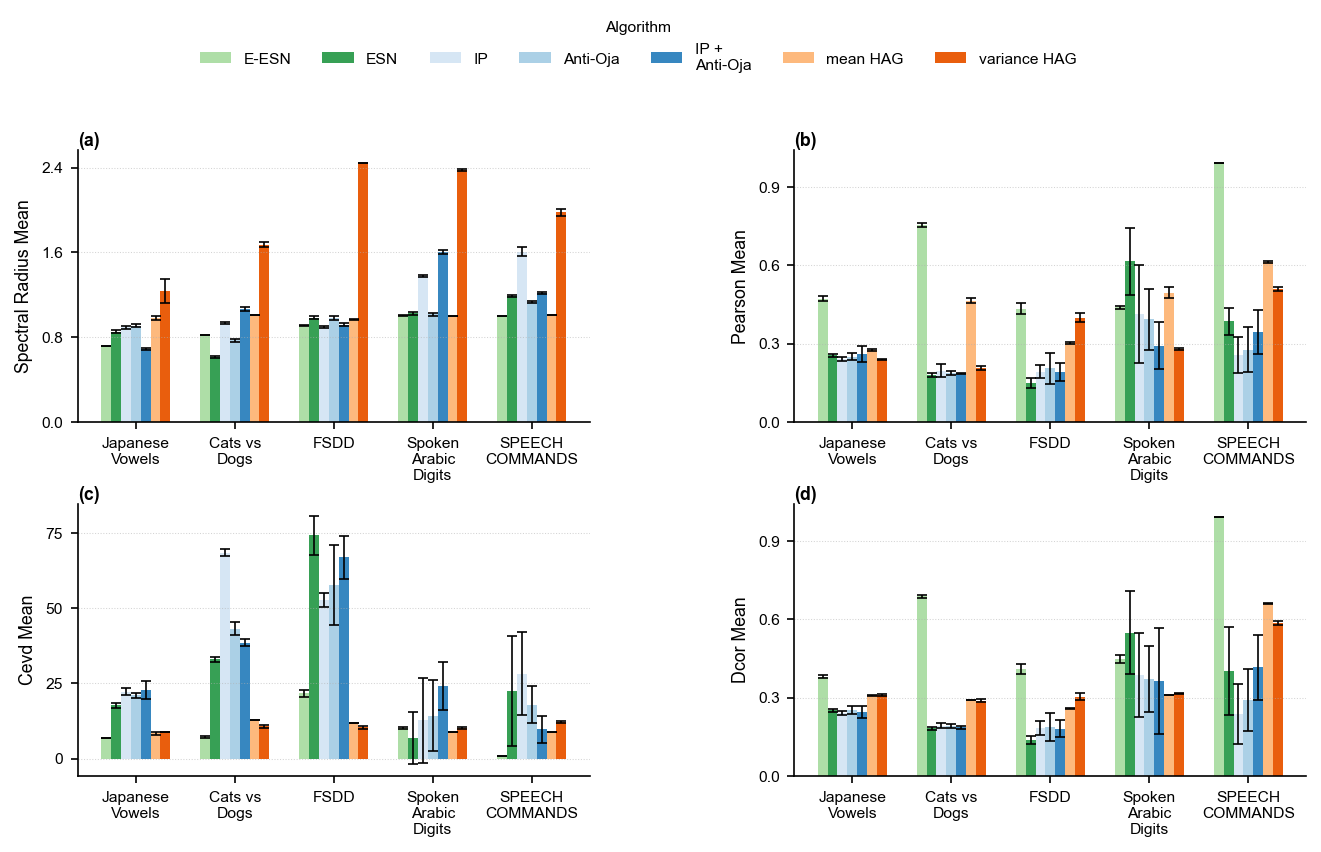

In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ---------- vector-friendly text (Nature likes real text in PDFs) ----------
mpl.rcParams['pdf.fonttype'] = 42      # embed TrueType
mpl.rcParams['ps.fonttype']  = 42
mpl.rcParams['svg.fonttype'] = 'none'  # keep text as text
mpl.rcParams['font.family']  = ['Arial', 'DejaVu Sans']  # Arial if available

# ------------------------------ load data -----------------------------------
file_name = 'outputs/metrics.csv'
data = pd.read_csv(file_name)

datasets_keep = [
    "JapaneseVowels",
    "CatsDogs",
    "FSDD",
    "SpokenArabicDigits",
    "SPEECHCOMMANDS",
]

label_map = {
    "JapaneseVowels":     "Japanese\nVowels",
    "CatsDogs":           "Cats vs\nDogs",
    "FSDD":               "FSDD",
    "SpokenArabicDigits": "Spoken\nArabic\nDigits",
    "SPEECHCOMMANDS":     "SPEECH\nCOMMANDS",
}

# Stable order present in file
datasets_order = [d for d in datasets_keep if d in data['dataset'].unique()]
dataset_labels = [label_map[d] for d in datasets_order]

data = data[data["dataset"].isin(datasets_order)].copy()
data["dataset"] = data["dataset"].map(label_map)

# Map algorithm names; don't drop rows if mapping missing
data["Algorithm"] = data["function_name"].map(function_mapping).fillna(data["function_name"])

# Keep only algorithms that actually appear, honoring your preferred order
algos_present = list(dict.fromkeys(data["Algorithm"].dropna()))
algos = [a for a in functions_order if a in algos_present] or algos_present

# ------------------------------- metrics ------------------------------------
metrics     = ["spectral_radius_mean", "pearson_mean", "CEVD_mean", "dcor_mean"]
err_metrics = ["spectral_radius_std",  "pearson_std",  "CEVD_std",  "dcor_std"]

# ------------------------------ layout knobs --------------------------------
fs_axis    = 8.5
fs_tick    = 7.5
width_bar  = min(0.72 / max(1, len(algos)), 0.10)   # slightly slimmer bars
x          = np.arange(len(datasets_order))

# 2×2 grid; reserve a slimmer band at the very top for legend; tighter hspace
fig, axes = plt.subplots(
    2, 2,
    figsize=(9.0, 5.8),
    gridspec_kw=dict(left=0.085, right=0.995, top=0.84, bottom=0.12,
                     wspace=0.40, hspace=0.30),
    constrained_layout=False
)
axes = axes.ravel()

handles = labels = None
panel_titles = ["(a)", "(b)", "(c)", "(d)"]   # panel labels only

for m, (metric, emetric) in enumerate(zip(metrics, err_metrics)):
    ax = axes[m]

    # Pivot to (dataset × algorithm) and align for equal-length series
    mean_p = (data.pivot_table(index="dataset", columns="Algorithm", values=metric,  aggfunc="mean")
                    .reindex(index=dataset_labels, columns=algos))
    std_p  = (data.pivot_table(index="dataset", columns="Algorithm", values=emetric, aggfunc="mean")
                    .reindex(index=dataset_labels, columns=algos))

    # Bars --------------------------------------------------------------------
    for i, alg in enumerate(algos):
        means  = mean_p[alg].to_numpy()
        errors = std_p[alg].to_numpy()
        ax.bar(x + i*width_bar, means, width_bar,
               label=alg, yerr=errors, capsize=2.5,
               color=function_colors.get(alg, None),
               error_kw={"elinewidth": 0.8, "capthick": 0.8})

    # Panel label only (no caption text)
    ax.set_title(panel_titles[m], loc='left', fontsize=fs_axis, fontweight='bold', pad=2)

    # Axis cosmetics
    ax.set_ylabel(metric.replace("_", " ").title(), fontsize=fs_axis)
    ax.set_xticks(x + width_bar*(len(algos)-1)/2)
    ax.set_xticklabels(dataset_labels, fontsize=fs_tick)
    ax.tick_params(axis="y", labelsize=fs_tick)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.grid(axis='y', linestyle=':', linewidth=0.5, alpha=0.55)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if m == 0:
        handles, labels = ax.get_legend_handles_labels()

# --------------------------- legend on TOP -----------------------------------
if handles and labels:
    fig.legend(handles, labels, title="Algorithm",
               ncol=min(7, len(labels)), frameon=False,
               fontsize=fs_tick, title_fontsize=fs_tick,
               loc="upper center", bbox_to_anchor=(0.5, 0.995), borderaxespad=0.0)

# -------------------------- save vector outputs ------------------------------
out_dir = "outputs/figures"
os.makedirs(out_dir, exist_ok=True)

pdf_path = os.path.join(out_dir, "Fig_dim_metrics_panel.pdf")

fig.savefig(pdf_path, bbox_inches="tight")  # PRIMARY: use this PDF for submission

# ------------------------------ quick preview --------------------------------
plt.show()

# Separability

In [ ]:
from scipy import stats
from numpy import random

# Evaluating
from performances.esn_model_evaluation import train_model_for_classification, predict_model_for_classification, compute_score
from performances.esn_model_evaluation import (train_model_for_prediction, init_reservoir, init_ip_reservoir, init_local_rule_reservoir, init_ip_local_rule_reservoir, init_readout)
from analysis.richness import spectral_radius, pearson, squared_uncoupled_dynamics_alternative, distance_correlation


from importlib import reload
import analysis.separability
from analysis.separability import (
    inter_intra_class_distance,
    fisher_discriminant_ratio,
    silhouette,
    davies_bouldin,
    calinski_harabasz
)
reload(analysis.separability)

nb_jobs = 10
def evaluate_dataset_on_test_alternative(study, dataset_name, function_name, pretrain_data, train_data, test_data, Y_train, Y_test, is_instances_classification, nb_trials = 8, record_metrics=False):
    # Collect all hyperparameters in a dictionary
    hyperparams = {param_name: param_value for param_name, param_value in study.best_trial.params.items()}
    print(hyperparams)
    leaky_rate = 1
    input_connectivity = 1

    # score for prediction
    if dataset_name == "Sunspot":
        start_step = 30
        end_step = 500
    else:
        start_step = 500
        end_step = 1500
    SLICE_RANGE = slice(start_step, end_step)

    if 'variance_target' not in hyperparams and 'min_variance' in hyperparams:
        hyperparams['variance_target'] = hyperparams['min_variance']
    if not is_instances_classification:
        hyperparams['use_full_instance'] = False

    RIDGE_COEF = 10**hyperparams['ridge']
    
    if function_name in ["hadsp", "desp"]:
        max_partners = np.inf
    
    inter_dists = []
    intra_dists = []
    separability_ratios = []
    sil_scores = []
    dbi_scores = []
    ch_scores  = []

    for i in range(nb_trials):
        print("Trial", i + 1, "of", nb_trials)
        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the models to be at least network_size
        K = math.ceil(hyperparams['network_size'] / common_size)
        n = common_size * K
        
        if function_name in ["diag_ee", "diag_ei"]:
            use_block = True
        else:
            use_block = False
            
        # UNSUPERVISED PRETRAINING 
        if function_name == "random_ee":
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(loc=0, scale=1), use_block=use_block, seed=random.randint(0, 1000))
        else:
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(loc=-1, scale=2), use_block=use_block, seed=random.randint(0, 1000))
        bias *= hyperparams['bias_scaling']
        Win *= hyperparams['input_scaling']

        if function_name == "hadsp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, 
                                     hyperparams['weight_increment'], hyperparams['target_rate'], hyperparams['rate_spread'], function_name, 
                                     multiple_instances=is_instances_classification, 
                                     min_increment = hyperparams['min_increment'], max_increment=hyperparams['max_increment'], use_full_instance=hyperparams['use_full_instance'],
                                     max_partners=max_partners, method="pearson", n_jobs=nb_jobs)
        elif function_name == "desp":
            print("DESP")
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, 
                                         hyperparams['weight_increment'], hyperparams['variance_target'], hyperparams['variance_spread'], function_name, 
                                         multiple_instances=is_instances_classification, 
                                         min_increment = hyperparams['min_increment'], max_increment=hyperparams['max_increment'], use_full_instance = hyperparams['use_full_instance'], 
                                         max_partners=max_partners, method = "pearson", 
                                         intrinsic_saturation=hyperparams['intrinsic_saturation'], intrinsic_coef=hyperparams['intrinsic_coef'], 
                                         n_jobs = nb_jobs)
        elif function_name in ["random_ee", "random_ei", "diag_ee", "diag_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))
        else:
            raise ValueError(f"Invalid function: {function_name}")
        
        # unsupervised local rules
        if is_instances_classification:
            unsupervised_pretrain = np.concatenate(pretrain_data).astype(float)
        else:
            unsupervised_pretrain = pretrain_data.astype(float)
        if function_name == "ip_correct":
            reservoir = init_ip_reservoir(W, Win, bias, mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                          leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function
                                          )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        elif function_name == "anti-oja_fast":
            reservoir = init_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                  synapse_normalization=False, bcm_theta=None,
                                                  leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                  )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)        
        elif function_name == "ip-anti-oja_fast":
            reservoir = init_ip_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                      synapse_normalization=False, bcm_theta=None,
                                                      mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                                      leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                      )
            _ = reservoir.fit(unsupervised_pretrain, warmup=100)
        else:
            reservoir = init_reservoir(W, Win, bias, leaky_rate, activation_function)
        readout = init_readout(ridge_coef=RIDGE_COEF)


        # TRAINING and EVALUATION
        # Step 1: Collect final hidden states
        final_states = []
        for seq in test_data:
            states = reservoir.run(seq)
            final_states.append(states[-1])

        final_states = np.array(final_states)  # (n_test, reservoir_dim)

        # Convert one-hot labels to flat labels
        if Y_test.ndim == 2:
            y_test = np.argmax(Y_test, axis=1)
        else:
            y_test = np.array(Y_test)

        # Step 2: Compute inter/intra class distances
        if is_instances_classification:
            inter_dist, intra_dist, sep_ratio = inter_intra_class_distance(final_states, y_test)
            sil = silhouette(final_states, y_test)
            dbi = davies_bouldin(final_states, y_test)
            ch  = calinski_harabasz(final_states, y_test)

            inter_dists.append(inter_dist)
            intra_dists.append(intra_dist)
            separability_ratios.append(sep_ratio)

            sil_scores.append(sil)
            dbi_scores.append(dbi)
            ch_scores.append(ch)

    return {
        'inter': inter_dists,
        'intra': intra_dists,
        'ratio': separability_ratios,
        'silhouette': sil_scores,
        'davies_bouldin': dbi_scores,
        'calinski_harabasz': ch_scores,
    }


In [ ]:
from performances.utility import retrieve_best_model

datasets = [
#    "JapaneseVowels",
#    "CatsDogs",
    "FSDD",
#    "SpokenArabicDigits",
#    "SPEECHCOMMANDS",
]


corr_columns = []
for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, \
        is_instances_classification = load_data(dataset, data_type, noise_std, visualize=False)

    for function_name in ["random_ee", "random_ei", "ip_correct", "anti-oja_fast",  "ip-anti-oja_fast", "hadsp", "desp"]: # "random_ee", "random_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast", "hadsp", "desp"
        print(function_name)

        study = retrieve_best_model(
            function_name, dataset, is_multivariate,
            variate_type="multi", data_type="normal"
        )

        results = evaluate_dataset_on_test_alternative(
            study, dataset, function_name,
            pretrain_data, train_data, test_data,
            Y_train, Y_test,
            is_instances_classification,
            nb_trials=4,
            record_metrics=True
        )

        # add *one* dict to corr_rows
        corr_columns.append({
            "dataset": dataset,
            "function_name": function_name,
            "inter_dists_mean": np.mean(results['inter']),
            "inter_dists_std":  np.std(results['inter']),
            "intra_dists_mean": np.mean(results['intra']),
            "intra_dists_std":  np.std(results['intra']),
            "separability_ratios_mean": np.mean(results['ratio']),
            "separability_ratios_std":  np.std(results['ratio']),
            "silhouette_mean": np.mean(results['silhouette']),
            "silhouette_std":  np.std(results['silhouette']),
            "davies_bouldin_mean": np.mean(results['davies_bouldin']),
            "davies_bouldin_std":  np.std(results['davies_bouldin']),
            "calinski_harabasz_mean": np.mean(results['calinski_harabasz']),
            "calinski_harabasz_std":  np.std(results['calinski_harabasz']),
        })


In [ ]:
file_name = "outputs/metrics.csv"

orig    = pd.read_csv(file_name).set_index(["dataset", "function_name"])
corr_df = pd.DataFrame(corr_columns).set_index(["dataset", "function_name"])

# Ensure all columns are present in both frames
for col in corr_df.columns:
    if col not in orig.columns:
        orig[col] = np.nan
for col in orig.columns:
    if col not in corr_df.columns:
        corr_df[col] = np.nan

# Prefer new results; keep existing where new is NaN.
merged = corr_df.combine_first(orig)

# (Optional) if you want new to OVERWRITE existing non-NaNs too:
merged = orig.copy()
merged = merged.reindex(merged.index.union(corr_df.index))
merged.loc[corr_df.index, corr_df.columns] = corr_df.values

# Write out
merged.reset_index().to_csv(file_name, index=False)

print(f"✔ Wrote {len(corr_df)} rows (added {len(set(corr_df.index) - set(orig.index))}, "
      f"updated {len(set(corr_df.index) & set(orig.index))}) to {file_name}")

## Visualize

/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_58698/1367663893.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_rank.set_xticklabels(rank_sums.index, rotation=45, ha="right", fontsize=fs_tick)


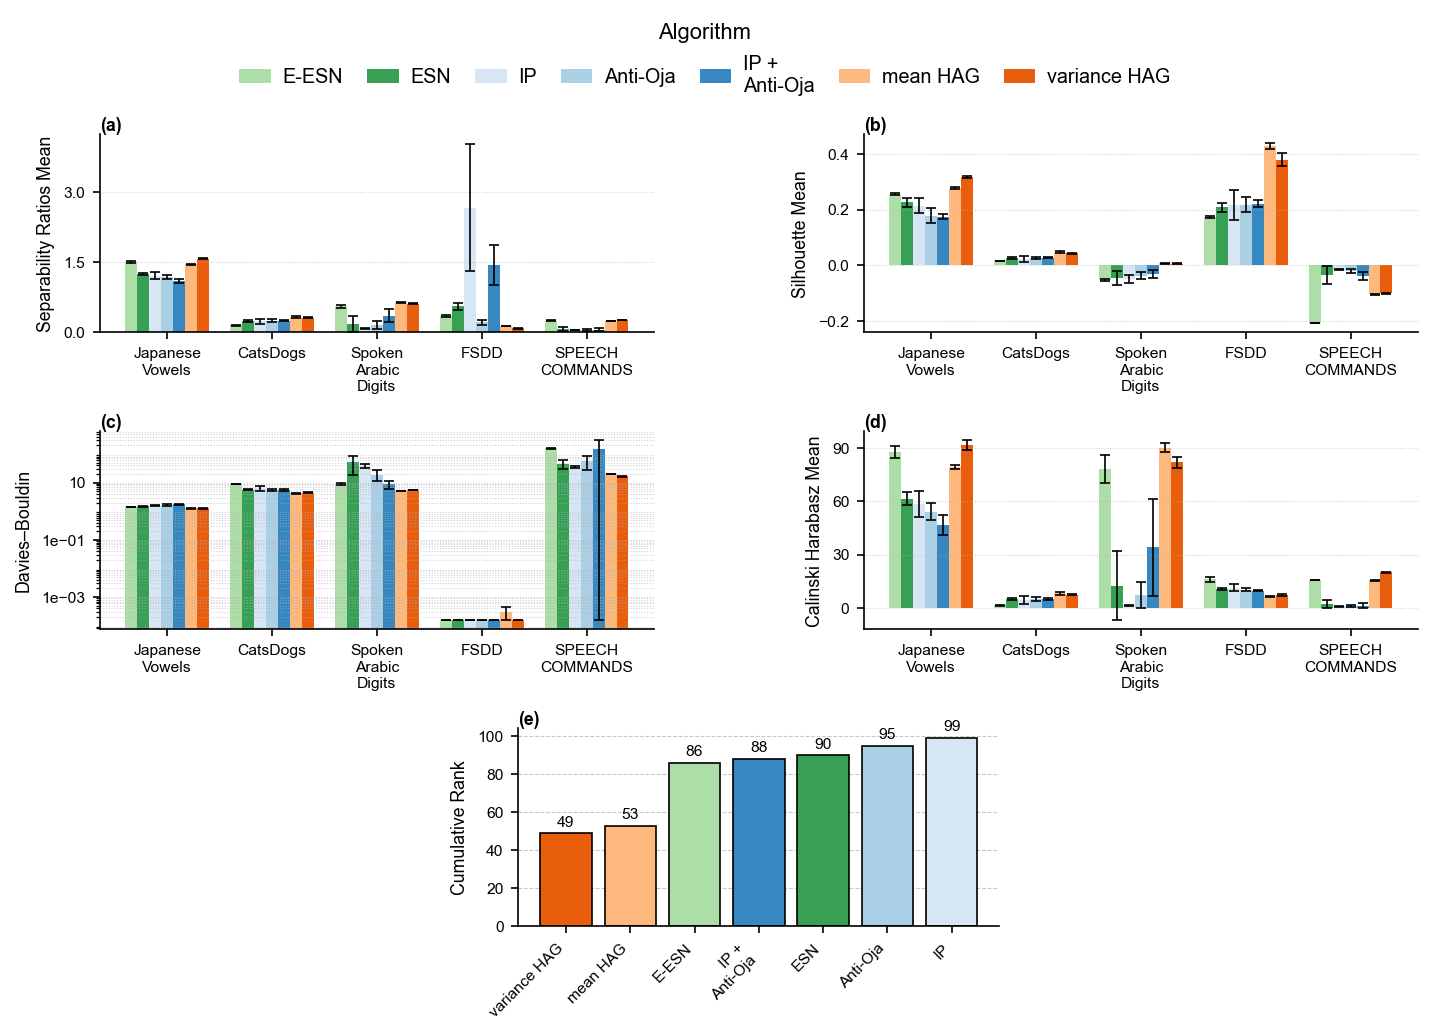

In [58]:
from matplotlib.ticker import MaxNLocator, LogLocator, LogFormatter

# ------------------------------------------------------------------
# imports (in case they weren't already)
# ------------------------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ------------------------------------------------------------------
# parameters + data
# ------------------------------------------------------------------
df = pd.read_csv("outputs/metrics.csv")

datasets = ["JapaneseVowels", "CatsDogs", "SpokenArabicDigits", "FSDD", "SPEECHCOMMANDS"]
df = df[df["dataset"].isin(datasets)].copy()

# FIX 1: make the label column name match what pivot_table expects ("dataset_label")
# FIX 2: use df["dataset"] (not data["dataset"])
label_map = {
    "SpokenArabicDigits": "Spoken\nArabic\nDigits",
    "SPEECHCOMMANDS":     "SPEECH\nCOMMANDS",
    "JapaneseVowels":     "Japanese\nVowels",
}
df["dataset_label"] = df["dataset"].replace(label_map)

# keep a label list in the same order as `datasets` for plotting/reindexing
dataset_labels = [label_map.get(d, d) for d in datasets]

# Map function_name -> display name; fall back to function_name if mapping missing
if "function_mapping" in locals():
    df["Algorithm"] = df["function_name"].map(function_mapping).fillna(df["function_name"])
else:
    df["Algorithm"] = df["function_name"]

# Choose algorithm order (if not pre-defined)
if "algos" not in locals():
    algos = list(pd.Index(df["Algorithm"].dropna().unique()))

# Basic plotting params (safe defaults if not defined earlier)
fs_axis = locals().get("fs_axis", 10)
fs_tick = locals().get("fs_tick", 9)

# Colors: use provided mapping if available; otherwise let Matplotlib choose defaults
function_colors = locals().get("function_colors", {a: None for a in algos})

# X positions for grouped bars
x = np.arange(len(dataset_labels))
width_bar = 0.8 / max(1, len(algos))

metrics = [
    # "inter_dists_mean",
    # "intra_dists_mean",
    "separability_ratios_mean",
    "silhouette_mean",
    "davies_bouldin_mean",
    "calinski_harabasz_mean",
]

error_metrics = [
    # "inter_dists_std",
    # "intra_dists_std",
    "separability_ratios_std",
    "silhouette_std",
    "davies_bouldin_std",
    "calinski_harabasz_std",
]

# ---------- figure: 2×2 top + centered narrow bottom (e) --------------------
fig = plt.figure(figsize=(9.6, 6.6))
gs = fig.add_gridspec(
    3, 2,
    left=0.08, right=0.995, top=0.90, bottom=0.10,
    wspace=0.38, hspace=0.5
)

axes_top = [
    fig.add_subplot(gs[0,0]),
    fig.add_subplot(gs[0,1]),
    fig.add_subplot(gs[1,0]),
    fig.add_subplot(gs[1,1]),
]

# --- create a 1×3 sub-grid only for the bottom row; center col is panel (e)
RANK_WIDTH_FRAC = 1.15   # smaller => narrower panel (e)
gs_bottom = gs[2, :].subgridspec(1, 3, width_ratios=[1.0, RANK_WIDTH_FRAC, 1.0], wspace=0.0)
ax_rank   = fig.add_subplot(gs_bottom[0, 1])   # center = panel (e)
# side “spacer” axes (hidden) so (e) is visually narrower
for side in (fig.add_subplot(gs_bottom[0, 0]), fig.add_subplot(gs_bottom[0, 2])):
    side.axis('off')

handles = labels = None
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]

# --------------------------- panels (a)-(d) ----------------------------------
for m, (metric, emetric) in enumerate(zip(metrics, error_metrics)):
    ax = axes_top[m]

    mean_p = (df.pivot_table(index="dataset_label", columns="Algorithm", values=metric, aggfunc="mean")
                .reindex(index=dataset_labels, columns=algos))

    if emetric in df.columns:
        std_p = (df.pivot_table(index="dataset_label", columns="Algorithm", values=emetric, aggfunc="mean")
                   .reindex(index=dataset_labels, columns=algos))
        use_yerr = True
    else:
        std_p = mean_p.copy()
        std_p.loc[:, :] = 0.0
        use_yerr = False

    # --- Davies–Bouldin on log scale, with visible ticks ---
    is_db = (metric == "davies_bouldin_mean")
    if is_db:
        ax.set_yscale("log")
        # positive floor for any 0/negatives so log scale is valid
        pos_vals = mean_p.to_numpy()
        pos_vals = pos_vals[np.isfinite(pos_vals) & (pos_vals > 0)]
        eps = float(pos_vals.min() * 0.5) if pos_vals.size else 1e-6
        # Log ticks + formatter so the scale is visible
        ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
        ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=12))
        ax.yaxis.set_major_formatter(LogFormatter(base=10.0))
        ax.grid(axis='y', which='both', linestyle=':', linewidth=0.5, alpha=0.6)
    else:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
        ax.grid(axis='y', linestyle=':', linewidth=0.5, alpha=0.6)

    for i, alg in enumerate(algos):
        means  = mean_p[alg].to_numpy()
        errors = std_p[alg].to_numpy() if use_yerr else None

        if is_db:
            means = np.where(~np.isfinite(means) | (means <= 0), eps, means)
            if use_yerr and errors is not None:
                errors = np.clip(errors, 0, means - eps)  # keep lower bar > 0

        ax.bar(x + i*width_bar, means, width_bar,
               label=alg, yerr=(errors if use_yerr else None),
               capsize=2.5 if use_yerr else 0.0,
               color=function_colors.get(alg, None),
               error_kw={"elinewidth": 0.8, "capthick": 0.8} if use_yerr else None)

    ax.set_title(panel_labels[m], loc='left', fontsize=fs_axis, fontweight='bold', pad=2)

    nice_name = metric.replace("_", " ").title()
    if metric == "davies_bouldin_mean":
        nice_name = "Davies–Bouldin"
    ax.set_ylabel(nice_name, fontsize=fs_axis)

    ax.set_xticks(x + width_bar*(len(algos)-1)/2)
    ax.set_xticklabels(dataset_labels, fontsize=fs_tick)
    ax.tick_params(axis="y", which="both", labelsize=fs_tick)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if m == 0:
        handles, labels = ax.get_legend_handles_labels()

# --------------------------- panel (e): cumulative ranking -------------------
# If rank_sums isn't already provided, compute it from the metrics
if "rank_sums" not in locals():
    # Define which direction is "better" for each metric
    lower_is_better = {"davies_bouldin_mean"}
    ranks_per_alg = pd.Series(0.0, index=algos, dtype=float)

    for metric in metrics:
        pivot = (df.pivot_table(index="dataset_label", columns="Algorithm", values=metric, aggfunc="mean")
                   .reindex(index=dataset_labels, columns=algos))
        if pivot.empty:
            continue
        ascending = metric in lower_is_better  # True -> lower rank is better
        # rank within each dataset (row-wise), then sum ranks over datasets
        # method="average" handles ties
        ranks = pivot.rank(axis=1, ascending=ascending, method="average")
        ranks_per_alg = ranks_per_alg.add(ranks.sum(skipna=True), fill_value=0.0)

    rank_sums = ranks_per_alg.sort_values()

colors = [function_colors.get(alg, None) for alg in rank_sums.index]
bars = ax_rank.bar(rank_sums.index, rank_sums.values, edgecolor='black', color=colors, linewidth=0.8)

ax_rank.set_title("(e)", loc='left', fontsize=fs_axis, fontweight='bold', pad=2)
ax_rank.set_ylabel("Cumulative Rank", fontsize=fs_axis)

ax_rank.spines['top'].set_visible(False)
ax_rank.spines['right'].set_visible(False)
ax_rank.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax_rank.set_axisbelow(True)
ax_rank.tick_params(axis="y", labelsize=fs_tick)
ax_rank.set_xticklabels(rank_sums.index, rotation=45, ha="right", fontsize=fs_tick)

ymax = float(rank_sums.max() if len(rank_sums) else 0)
for bar, val in zip(bars, rank_sums.values):
    ax_rank.text(
        bar.get_x() + bar.get_width() * 0.5,
        bar.get_height() + (0.02 * ymax if ymax > 0 else 0.2),
        f"{int(round(val))}",
        ha='center', va='bottom', fontsize=fs_tick
    )

# --------------------------- bigger legend on TOP ----------------------------
LEGEND_FS        = 9.5    # larger legend text
LEGEND_TITLE_FS  = 10.5
if handles and labels:
    fig.legend(
        handles, labels, title="Algorithm",
        ncol=min(7, len(labels)),
        frameon=False,
        fontsize=LEGEND_FS, title_fontsize=LEGEND_TITLE_FS,
        handlelength=1.6, handletextpad=0.6, columnspacing=1.2, labelspacing=0.6,
        loc="upper center", bbox_to_anchor=(0.5, 1.025), borderaxespad=0.2
    )

# -------------------------- save vector outputs ------------------------------
os.makedirs("outputs/figures", exist_ok=True)
fig.savefig("outputs/figures/Fig_cluster_metrics_panel.pdf", bbox_inches="tight")
plt.show()

In [ ]:
import pandas as pd

# Lire le CSV
df = pd.read_csv("outputs/metrics.csv")

# Arrondir toutes les colonnes numériques à 5 décimales
df = df.round(5)

# Sauvegarder le fichier modifié (optionnel)
df.to_csv("outputs/metrics_rounded.csv", index=False)

print("Fichier arrondi sauvegardé dans outputs/metrics_rounded.csv")

## Ranking

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and filter data
data = pd.read_csv("outputs/metrics.csv")
datasets = ["JapaneseVowels", "CatsDogs", "SpokenArabicDigits", "FSDD", "SPEECHCOMMANDS"]
df = data[data["dataset"].isin(datasets)].copy()

# Map function names to algorithm names
df["Algorithm"] = df["function_name"].map(function_mapping)

# Metrics used
metrics = [
    "separability_ratios_mean",
    "silhouette_mean",
    "davies_bouldin_mean",
    "calinski_harabasz_mean"
]

# Average metrics per dataset-algorithm combination
agg = df.groupby(["dataset", "Algorithm"])[metrics].mean().reset_index()

algorithms = ["E-ESN", "ESN", "IP", "Anti-Oja", "IP +\nAnti-Oja", "mean HAG", "variance HAG"]
rank_sums = pd.Series(0, index=algorithms)

# Compute ranks and sum across all dataset × metric combinations
for ds in datasets:
    sub = agg[agg["dataset"] == ds].set_index("Algorithm")
    for metric in metrics:
        ascending = metric == "davies_bouldin_mean"  # lower is better for DB, higher for others
        ranks = sub[metric].rank(ascending=ascending, method="min")
        rank_sums += ranks.reindex(algorithms)

# Sort by cumulative rank sums
rank_sums = rank_sums.sort_values()

# --------------
# Plot

# Plotting cumulative rank sums (polished for publication)
plt.figure(figsize=(8, 5))
colors = [function_colors[alg] for alg in rank_sums.index]
bars = plt.bar(rank_sums.index, rank_sums.values, edgecolor='black', color=colors, linewidth=0.8)

# Clean up spines 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal grid lines for readability
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

# Labels and title in bold
plt.ylabel("Cumulative Rank Sum", fontsize=12, fontweight='bold')

# Ticks styling
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)

# Annotate bars with integer labels
ymax = rank_sums.max()
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() * 0.5,
        height + ymax * 0.02,
        f"{int(height)}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Final matrix

In [ ]:
from performances.utility import camel_to_snake, retrieve_best_model
from models.reservoir import init_matrices
from hag.hag import run_algorithm
from scipy import sparse

# List of datasets
classification = [
    "JapaneseVowels",
    "CatsDogs",
    "FSDD",
    "SpokenArabicDigits",
    "SPEECHCOMMANDS",
]

prediction = [
    "MackeyGlass",
    "Lorenz",
    "Sunspot_daily",
]
datasets=prediction


# Initialize lists to store results and max values
Ws = []
titles = []
max_values = []

leaky_rate = 1
input_connectivity = 1

# Loop through datasets and function names to compute W matrices and find global vmax
for dataset in datasets:
    print(dataset)
    pretrain_data, train_data, test_data, Y_train, Y_test, is_multivariate, is_instances_classification = load_data(dataset, data_type, noise_std)

    # "random_ee", "random_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast",  "hadsp", "desp", "diag_ee", "diag_ei"
    for function_name in ["random_ee", "random_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast",  "hadsp", "desp"]: #"diag_ee", "diag_ei",
        print(function_name)
        # Get the best trial from the study
        study = retrieve_best_model(function_name, dataset, is_multivariate, variate_type = "multi", data_type = "normal")
        hyperparams = {param_name: param_value for param_name, param_value in study.best_trial.params.items()}
        print(hyperparams)

        if 'variance_target' not in hyperparams and 'min_variance' in hyperparams:
            hyperparams['variance_target'] = hyperparams['min_variance']
        if not is_instances_classification:
            hyperparams['use_full_instance'] = False
    
        if function_name in ["hadsp", "desp"]:
            max_partners = np.inf
        
        common_index = 1
        if is_instances_classification:
            common_size = pretrain_data[0].shape[common_index]
        else:
            common_size = pretrain_data.shape[common_index]

        # We want the size of the models to be at least network_size
        K = math.ceil(hyperparams["network_size"] / common_size)
        n = common_size * K
        
        if function_name in ["diag_ee", "diag_ei"]:
            use_block = True
        else:
            use_block = False
            
        # UNSUPERVISED PRETRAINING 
        if function_name == "random_ee":
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(loc=0, scale=1), use_block=use_block, seed=random.randint(0, 1000))
        else:
            Win, W, bias = init_matrices(n, input_connectivity, hyperparams['connectivity'],  K, w_distribution=stats.uniform(loc=-1, scale=2), use_block=use_block, seed=random.randint(0, 1000))
        bias *= hyperparams['bias_scaling']
        Win *= hyperparams['input_scaling']

        if function_name == "hadsp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, 
                                     hyperparams['weight_increment'], hyperparams['target_rate'], hyperparams['rate_spread'], function_name, 
                                     multiple_instances=is_instances_classification, 
                                     min_increment = hyperparams['min_increment'], max_increment=hyperparams['max_increment'], use_full_instance=hyperparams['use_full_instance'],
                                     max_partners=max_partners, method="pearson", n_jobs=nb_jobs)
        elif function_name == "desp":
            W, (_, _, _) = run_algorithm(W, Win, bias, hyperparams['leaky_rate'], activation_function, pretrain_data, 
                                         hyperparams['weight_increment'], hyperparams['variance_target'], hyperparams['variance_spread'], function_name, 
                                         multiple_instances=is_instances_classification, 
                                         min_increment = hyperparams['min_increment'], max_increment=hyperparams['max_increment'], use_full_instance = hyperparams['use_full_instance'], 
                                         max_partners=max_partners, method = "pearson", 
                                         intrinsic_saturation=hyperparams['intrinsic_saturation'], intrinsic_coef=hyperparams['intrinsic_coef'], 
                                         n_jobs = nb_jobs)
        elif function_name in ["random_ee", "random_ei"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))
            
        elif function_name in ["ip_correct", "anti-oja_fast", "ip-anti-oja_fast"]:
            eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
            W *= hyperparams['spectral_radius'] / max(abs(eigen))

            # unsupervised local rules
            if is_instances_classification:
                unsupervised_pretrain = np.concatenate(pretrain_data).astype(float)
            else:
                unsupervised_pretrain = pretrain_data.astype(float)
            if function_name == "ip_correct":
                reservoir = init_ip_reservoir(W, Win, bias, mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                              leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function
                                              )
                _ = reservoir.fit(unsupervised_pretrain, warmup=100)
            elif function_name == "anti-oja_fast":
                reservoir = init_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                       synapse_normalization=True, bcm_theta=None,
                                                       leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                       )
                _ = reservoir.fit(unsupervised_pretrain, warmup=100)
            elif function_name == "ip-anti-oja_fast":
                reservoir = init_ip_local_rule_reservoir(W, Win, bias, local_rule="anti-oja", eta=hyperparams['oja_eta'],
                                                          synapse_normalization=True, bcm_theta=None,
                                                          mu=hyperparams['mu'], sigma=hyperparams['sigma'], learning_rate=hyperparams['learning_rate'],
                                                          leaking_rate=hyperparams['leaky_rate'], activation_function=activation_function,
                                                          )
                _ = reservoir.fit(unsupervised_pretrain, warmup=100)
            else:
                reservoir = init_reservoir(W, Win, bias, leaky_rate, activation_function)

            W = reservoir.W
            

        # Store W matrix and corresponding title
        Ws.append(W)
        titles.append(f"{dataset} - {[function_name]}")
        max_values.append(np.max(W))


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib as mpl
from matplotlib import ticker

# --- robust global range (clip outliers) ---
abs_vals = np.abs(all_values[np.isfinite(all_values)])
gmax = np.quantile(abs_vals, 0.995)                    # 99.5% clip; adjust if you want more/less contrast
linthresh = max(gmax * 0.02, 1e-8)                     # linear region around 0 (~2% of range)

# symmetric log normalization around 0 (expands colors near zero)
norm = mcolors.SymLogNorm(linthresh=linthresh, vmin=-gmax, vmax=gmax, base=10)

# a higher-contrast diverging cmap; 'RdBu_r' is crisper than 'seismic'
cmap = plt.get_cmap('RdBu_r')


# --- use the same order you trained with ---
functions_order = ["random_ee", "random_ei", "ip_correct", "anti-oja_fast", "ip-anti-oja_fast", "hadsp", "desp"]

n_datasets  = len(datasets)
n_functions = len(functions_order)

# Safety check: did we compute one W per (dataset, function)?
expected = n_datasets * n_functions
if len(Ws) != expected:
    raise ValueError(
        f"Mismatch: have {len(Ws)} W matrices for {n_datasets} datasets × {n_functions} functions "
        f"(expected {expected}). Ensure functions_order matches the training loop."
    )

# (optional) embed TrueType fonts so PDF text is selectable
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42

# --- global min/max across all Ws (so colors are comparable) ---
all_values = []
for W in Ws:
    if hasattr(W, "toarray"):
        W = W.toarray()
    all_values.append(W.ravel())
all_values = np.concatenate(all_values)
global_abs_max = np.max(np.abs(all_values))
g_vmin, g_vmax = -global_abs_max, global_abs_max

# --- figure ---
fig, axes = plt.subplots(
    n_datasets, 
    n_functions, 
    figsize=(n_functions * 3, n_datasets * 3),
    sharex=True, 
    sharey=True
)

# Ensure axes is 2D even if a dimension is 1
if n_datasets == 1:
    axes = np.array([axes])
if n_functions == 1:
    axes = np.array([axes]).T

im = None
for i in range(n_datasets):
    for j in range(n_functions):
        idx = i * n_functions + j  
        W = Ws[idx]
        if hasattr(W, "toarray"):
            W = W.toarray()

        # draw heatmap using a symmetric global scale for comparability
        im = axes[i, j].imshow(
            W,
            cmap=cmap,
            norm=norm,
            interpolation='nearest'
        )
        # overlay zeros in white
        zero_mask = (W == 0)
        axes[i, j].imshow(
            np.ma.masked_where(~zero_mask, W),
            cmap=mcolors.ListedColormap(['white']),
            interpolation='nearest'
        )

        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

        if j == 0:
            axes[i, j].text(
                -0.3, 0.5, datasets[i],
                rotation=90,
                transform=axes[i, j].transAxes,
                ha='center',
                va='center',
                fontsize=15
            )
        if i == 0:
            axes[i, j].set_title(functions_order[j], fontsize=15)

# shared labels
fig.text(0.5, 0.005, 'Neurons', ha='center', va='center', fontsize=14)
fig.text(0.015, 0.5, 'Neurons', ha='center', va='center', rotation='vertical', fontsize=14)

fig.tight_layout()

# single colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.03, pad=0.01)
cbar.set_label('Recurrent weight strength', fontsize=12)

# helpful symmetric ticks
tick_vals = np.array([ -gmax, -gmax/10, -linthresh, 0, linthresh, gmax/10, gmax ])
cbar.set_ticks(tick_vals)
cbar.ax.set_yticklabels([f'{t:.2g}' for t in tick_vals])

if 'classification' in locals() and set(datasets).issubset(set(classification)):
    out_base = 'outputs/figures/connectivity_matrices_classification'
elif 'prediction' in locals() and set(datasets).issubset(set(prediction)):
    out_base = 'outputs/figures/connectivity_matrices_forecasting'
    
# save PDF
fig.savefig(f'{out_base}.pdf', bbox_inches='tight')

plt.show()



# Cumulated visualisation

In [ ]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import xml.etree.ElementTree as ET
from svgpath2mpl import parse_path
from matplotlib.markers import MarkerStyle

# ---------- vector-friendly text (keep text as text in PDF/SVG) ----------
mpl.rcParams['pdf.fonttype'] = 42      # embed TrueType
mpl.rcParams['ps.fonttype']  = 42
mpl.rcParams['svg.fonttype'] = 'none'  # keep text as text
mpl.rcParams['font.family']  = ['Arial', 'DejaVu Sans']  # Arial if available

def make_colorable_marker(svg_path, scale=1.0):
    tree = ET.parse(svg_path)
    root = tree.getroot()
    ns = {"svg": "http://www.w3.org/2000/svg"}
    d_list = [p.attrib["d"] for p in root.findall(".//svg:path", ns)]
    full_d = " ".join(d_list)
    p = parse_path(full_d)
    p.vertices[:, 1] *= -1
    p.vertices -= p.vertices.mean(axis=0)
    p.vertices *= scale
    return MarkerStyle(p)

file_name = "outputs/metrics.csv"
performance_file = "outputs/test_results/test_results_classification.csv"
data = pd.read_csv(file_name)
performance = pd.read_csv(performance_file)

# ---------- keep the following datasets -------------------------
datasets_keep = [ "JapaneseVowels", "CatsDogs", "SpokenArabicDigits", "FSDD", "SPEECHCOMMANDS"]
data = data[data["dataset"].isin(datasets_keep)]

# ---------- map functions and datasets → human-readable ------
data["dataset"] = (data["dataset"]
                   .str.replace("SpokenArabicDigits", "Spoken\nArabic\nDigits")
                   .str.replace("SPEECHCOMMANDS",     "SPEECH\nCOMMANDS")
                   .str.replace("JapaneseVowels",     "Japanese\nVowels"))
data["Algorithm"] = data["function_name"].map(function_mapping)

# ---------- marker for every dataset ---------------------
dataset_marker = {
    "CatsDogs":               r"$🐱$",  # ⚠️ If this glyph is missing, swap to an SVG via make_colorable_marker(...)
    "Japanese\nVowels":       r"$¥$",
    "Spoken\nArabic\nDigits":  make_colorable_marker("analysis/icons/arabic.svg", scale=0.015),
    "FSDD":                   r"$5$",
    "SPEECH\nCOMMANDS":       make_colorable_marker("analysis/icons/microphone.svg", scale=0.015),
}

# ---------- aggregate to one point per (Algorithm, Dataset) ----
group = (
    data.groupby(["Algorithm", "dataset"])
        .mean(numeric_only=True)
        .reset_index()
)

# ---------- merge in performance -----------
performance["Algorithm"] = performance["Function"].map(function_mapping)
performance["dataset"] = (
    performance["Dataset"]
    .str.replace("SpokenArabicDigits", "Spoken\nArabic\nDigits")
    .str.replace("SPEECHCOMMANDS",     "SPEECH\nCOMMANDS")
    .str.replace("JapaneseVowels",     "Japanese\nVowels")
)
performance["score"] = (
    performance["Average Score"]
    .str.replace("%", "", regex=False)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

group = pd.merge(
    group,
    performance[["Algorithm", "dataset", "score"]],
    on=["Algorithm", "dataset"],
    how="left"
)

# Normalize performance per dataset and size the markers
group["score"] = group.groupby("dataset")["score"].transform(
    lambda x: (x - x.min()) / (x.max() - x.mean() if (x.max() - x.min()) == 0 else (x.max() - x.min()))
)
group["size"] = group["score"] * 1000  # Scale for visibility

# ---------------------------------------------------------------
# 3)  Scatter plot :   decorrelation  vs  separability_score
# ---------------------------------------------------------------
metric_x = "CEVD_mean"
metric_y = "intra_dists_mean"

group['x_norm'] = group.groupby("dataset")[metric_x].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
group['y_norm'] = group.groupby("dataset")[metric_y].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

for _, row in group.iterrows():
    alg = row["Algorithm"]
    ds  = row["dataset"]
    ax.scatter(
        row[metric_x], row[metric_y],
        marker=dataset_marker.get(ds, "o"),
        s=row["size"],
        edgecolor="none",
        facecolor=function_colors[alg],
        linewidths=1.2,
        zorder=3
    )

# ---------- legends ---------------------------------------------
alg_handles = [
    Line2D([0], [0], marker="o", linestyle="",
           markersize=12, markeredgecolor="none",
           markerfacecolor=clr, label=alg)
    for alg, clr in function_colors.items()
]

ds_handles = [
    Line2D([0], [0], marker=mk, linestyle="",
           markersize=14, markeredgecolor="none",
           markerfacecolor="black",
           label=ds.replace("\n", " "))
    for ds, mk in dataset_marker.items()
]

legend1 = ax.legend(alg_handles, function_colors.keys(), title="Algorithm", loc="upper left", frameon=False)
ax.add_artist(legend1)
ax.legend(ds_handles, [d.replace("\n", " ") for d in dataset_marker], title="Dataset", loc="upper right", frameon=False)

# ---------- cosmetics -------------------------------------------
for side in ("left", "bottom"):
    ax.spines[side].set_visible(True)
    ax.spines[side].set_linewidth(1.3)
    ax.spines[side].set_color("black")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")

ax.set_xlabel(metric_x.replace("_", " ").title(), fontsize=16)
ax.set_ylabel(metric_y.replace("_", " ").title(), fontsize=16)
ax.grid(alpha=0.3)
plt.tight_layout()

# ---------- SAVE VECTOR OUTPUTS (PDF primary, SVG optional) -----
out_dir = "outputs/figures"
os.makedirs(out_dir, exist_ok=True)
pdf_path = os.path.join(out_dir, "Fig_scatter_CEVD_vs_Intra.pdf")   # <-- use this PDF in submission

fig.savefig(pdf_path, bbox_inches="tight")      # vector PDF with embedded fonts
fig.savefig(svg_path, bbox_inches="tight")      # optional SVG for editing

plt.show()
print(f"Saved:\n - {pdf_path}\n - {svg_path}")